In [1]:
import numpy as np
import scipy

from scipy import linalg
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib.cm as cmap
import matplotlib
import os
import pandas as pd

import math
import re
import natsort

from numpy import absolute as A
from numpy import transpose as T

#import natsort

import cv2
import time
import matplotlib.pyplot as plt

import networkx as nx

import umap
import seaborn as sns

import statsmodels.api

from scipy.stats import ttest_ind

##import pygad


from scipy import signal

def rand_sign():
    return 1 if np.random.rand() < 0.5 else -1

In [26]:


def weight_limits(W_raw, W_ref, tolerance=0.20):
    """
    Clip W_raw to lie within a tolerance band around W_ref,
    preserving reference sign pattern and zeros, and scaling reference
    to the max abs of the masked raw matrix.

    """
    
    # Mask: zeros in reference remain zeros
    mask_nonzero = (W_ref != 0)
    W_masked = np.zeros_like(W_raw)
    W_masked[mask_nonzero] = W_raw[mask_nonzero]
    
    # Scale reference so its max abs matches masked raw's max abs
    max_abs_masked_raw = np.max(np.abs(W_masked))
    max_abs_ref = np.max(np.abs(W_ref[mask_nonzero]))
        
    
    W_ref_scaled = W_ref / max_abs_ref * max_abs_masked_raw
    
    
    # Tolerance bands
    W_min = W_ref_scaled * (1 - tolerance)
    W_max = W_ref_scaled * (1 + tolerance)
    
    # Force raw to have reference's sign
    sign_ref = np.sign(W_ref)
    W_signed = np.abs(W_masked) * sign_ref
    
    # Clip with negative bound handling
    W_clipped = np.zeros_like(W_signed)
    for idx, _ in np.ndenumerate(W_signed):
        if mask_nonzero[idx]:
            lo = W_min[idx]
            hi = W_max[idx]
            if lo > hi:  # swap if needed for negatives
                lo, hi = hi, lo
            W_clipped[idx] = np.clip(W_signed[idx], lo, hi)
    
    # Ensure zeros
    W_clipped[~mask_nonzero] = 0
    
    return W_clipped



def plant_joint(flex_rate,ext_rate,ang, ang_min, ang_max):
    
    ang_vel_max = 20
    
    ang_vel = ext_rate - flex_rate
    if A(ang_vel) > ang_vel_max:
        ang_vel = ang_vel_max*np.sign(ang_vel)
    ang = ang + ang_vel
    

    if ang>A(ang_max):
        ang=ang_max*np.sign(ang)
    if ang<A(ang_min):
        ang=ang_min*np.sign(ang)      
        
    return ang, ang_vel    


def leg_construction (ang_0,ang_1,ang_2,Left_leg):
    
    
    D_0 = 3
    D_1 = 3
    D_2 = 5

    joint_positions_XY = np.random.randint(100,size=(3,2))

    pos_x_j2, pos_y_j2 = angle2pos(ang_2,D_2,Left_leg)
    
    ang_fc_1 = (180-ang_1)+ang_2 
    
    pos_x, pos_y = angle2pos(ang_fc_1,D_1,Left_leg)
    pos_x_j1 =  pos_x_j2 + pos_x
    pos_y_j1 =  pos_y_j2 + pos_y
    
    ang_fc_0 = (180-ang_0)+ang_fc_1
    
    pos_x, pos_y = angle2pos(ang_fc_0,D_0,Left_leg)
    pos_x_j0 =  pos_x_j1 + pos_x
    pos_y_j0 =  pos_y_j1 + pos_y
    
    joint_positions_XY[2,0] = pos_x_j2
    joint_positions_XY[2,1] = pos_y_j2
    joint_positions_XY[1,0] = pos_x_j1
    joint_positions_XY[1,1] = pos_y_j1
    joint_positions_XY[0,0] = pos_x_j0
    joint_positions_XY[0,1] = pos_y_j0
    
    return joint_positions_XY

def angle2pos (ang,D,Left_leg):
    ang = ang 

    ang_rad=np.radians(ang)#*(-1)
    #D_2=20

    pos_x = int(np.cos(ang_rad)*D)
    if Left_leg == True:
        pos_y = int(np.sin(ang_rad)*D)*(-1)
    else: pos_y = int(np.sin(ang_rad)*D)
    
    return pos_x, pos_y


def leg_collision(Xfc_left,Yfc_left,Xfc_right,Yfc_right):

    leg_collision = False

    eu_dist = np.sqrt((Xfc_left - Xfc_right)**2 + (Yfc_left - Yfc_right)**2) 


    if eu_dist<5:
        leg_collision = True
        
    return leg_collision   



def create_excit_net ():

    #ch=3
    #sense_sq_area = 26
    
    ch=1
    sense_sq_area = 20
    add_sensors = 2 + 12
    
    input_net_size = sense_sq_area*sense_sq_area*ch + add_sensors
    hidden_net_size_1 = 40
    numb_outputs = 13+4+4

    model_excit_net = Model_excitatory_net(input_net_size, hidden_net_size_1, numb_outputs)
    
    return model_excit_net


def solution2weights (solution):
    
    #channels = 3
    #sensors_numb = 26*26*channels
    
    channels = 1
    #sensors_numb = 6*6*channels
    sensors_numb = 20*20*channels + 2 + 12
    
    #sensors_numb = 100*100
    hidden_size = 40
    output_size = 13+4+4
    #print(sensors_numb*hidden_size)
    W_sens_hidden=np.reshape(solution[0:sensors_numb*hidden_size], (sensors_numb, hidden_size))
    
    W_hidden=np.reshape(solution[sensors_numb*hidden_size : sensors_numb*hidden_size+hidden_size*hidden_size], (hidden_size,hidden_size))
    
    W_hidden_out=np.reshape(solution[sensors_numb*hidden_size+hidden_size*hidden_size : sensors_numb*hidden_size+hidden_size*hidden_size+hidden_size*output_size],(hidden_size,output_size))
    
    Th_all = solution[18680:18680+467]
    Th_sens = Th_all[0:sensors_numb]
    Th_hidden = Th_all[sensors_numb : sensors_numb+hidden_size]
    Th_out = Th_all[sensors_numb+hidden_size : sensors_numb+hidden_size+output_size]
    
    return W_sens_hidden,W_hidden,W_hidden_out,Th_sens,Th_hidden,Th_out


def create_all_learnable_params(sol_part):
    
    tolerance = 0.2
    
    W_mat_13A_freeze = np.zeros((2,2))
    W_mat_13B_freeze = np.zeros((2,1))
    W_13A_MN_freeze = np.zeros((2,6))
    W_mat_SN_13A_freeze = np.zeros((6,2))
    W_mat_SN_MNs_freeze = np.zeros((6,6))

    W_mat_13A_freeze[0,1]=-559
    W_mat_13A_freeze[1,0]=-488
    
    W_mat_13B_freeze[0,0]=-413
    W_mat_13B_freeze[1,0]=-160
    
    W_13A_MN_freeze[0,1:3] = -1525
    W_13A_MN_freeze[1,4:6] = -1594
    W_13A_MN_freeze[0,0] = -1594
    W_13A_MN_freeze[1,3] = -1525

    W_mat_SN_13A_freeze[0:3,0] = 526
    W_mat_SN_13A_freeze[3:6,0] = 153
    W_mat_SN_13A_freeze[3:6,1] = 48

    W_mat_SN_MNs_freeze[0:3,3:6] = 244
    W_mat_SN_MNs_freeze[3:6,0:3] = 548

    W_mat_13B = np.reshape(sol_part[0:2],(2,1))
    W_mat_13A = np.reshape(sol_part[2:2+4],(2,2))
    W_13A_MN = np.reshape(sol_part[6:6+12],(2,6))
    W_mat_SN = np.reshape(sol_part[18:18+6],(6,1))
    W_mat_SN_13A = np.reshape(sol_part[24:24+12],(6,2))
    W_mat_SN_MNs = np.reshape(sol_part[36:36+36],(6,6))

    W_mat_13B = weight_limits(W_mat_13B,W_mat_13B_freeze, tolerance)     
    W_mat_13A = weight_limits(W_mat_13A,W_mat_13A_freeze, tolerance) 
    W_13A_MN  = weight_limits(W_13A_MN,W_13A_MN_freeze, tolerance)
          
    W_mat_SN_13A  = weight_limits(W_mat_SN_13A,W_mat_SN_13A_freeze, tolerance)
    W_mat_SN_MNs  = weight_limits(W_mat_SN_MNs,W_mat_SN_MNs_freeze, tolerance)

    Th_vec_13B = np.reshape(sol_part[72:72+2],(2,1))
    Th_vec_13A = np.reshape(sol_part[74:74+2],(2,1))
    Th_MNs = np.reshape(sol_part[76:76+6],(6,1))
    Th_SNs = np.reshape(sol_part[82:82+6],(6,1))
    
    return W_mat_13B, W_mat_13A, W_13A_MN, W_mat_SN, W_mat_SN_13A, W_mat_SN_MNs,Th_vec_13B, Th_vec_13A,  Th_MNs, Th_SNs

def genome_adjustment(sol_part, tolerance=0.2):
    """
    Adjust genome vector by clipping weight matrices according to their reference matrices
    and tolerance, preserving original layout in sol_part.
    """
    sol_part = np.array(sol_part, dtype=float)  # Ensure numpy array for in-place ops

    # Reference matrices
    W_mat_13A_freeze = np.zeros((2,2))
    W_mat_13B_freeze = np.zeros((2,1))
    W_13A_MN_freeze = np.zeros((2,6))
    W_mat_SN_13A_freeze = np.zeros((6,2))
    W_mat_SN_MNs_freeze = np.zeros((6,6))

    W_mat_13A_freeze[0,1] = -559
    W_mat_13A_freeze[1,0] = -488

    W_mat_13B_freeze[0,0] = -413
    W_mat_13B_freeze[1,0] = -160

    W_13A_MN_freeze[0,1:3] = -1525
    W_13A_MN_freeze[1,4:6] = -1594
    W_13A_MN_freeze[0,0] = -1594
    W_13A_MN_freeze[1,3] = -1525

    W_mat_SN_13A_freeze[0:3,0] = 526
    W_mat_SN_13A_freeze[3:6,0] = 153
    W_mat_SN_13A_freeze[3:6,1] = 48

    W_mat_SN_MNs_freeze[0:3,3:6] = 244
    W_mat_SN_MNs_freeze[3:6,0:3] = 548

    # Extract matrices from genome
    W_mat_13B     = np.reshape(sol_part[0:2], (2,1))
    W_mat_13A     = np.reshape(sol_part[2:2+4], (2,2))
    W_13A_MN      = np.reshape(sol_part[6:6+12], (2,6))
    W_mat_SN      = np.reshape(sol_part[18:18+6], (6,1))
    W_mat_SN_13A  = np.reshape(sol_part[24:24+12], (6,2))
    W_mat_SN_MNs  = np.reshape(sol_part[36:36+36], (6,6))

    # Clip
    W_mat_13B    = weight_limits(W_mat_13B, W_mat_13B_freeze, tolerance)
    W_mat_13A    = weight_limits(W_mat_13A, W_mat_13A_freeze, tolerance)
    W_13A_MN     = weight_limits(W_13A_MN, W_13A_MN_freeze, tolerance)
    W_mat_SN_13A = weight_limits(W_mat_SN_13A, W_mat_SN_13A_freeze, tolerance)
    W_mat_SN_MNs = weight_limits(W_mat_SN_MNs, W_mat_SN_MNs_freeze, tolerance)

    # Write clipped values back into genome
    sol_part[0:2]       = W_mat_13B.flatten()
    sol_part[2:2+4]     = W_mat_13A.flatten()
    sol_part[6:6+12]    = W_13A_MN.flatten()
    sol_part[18:18+6]   = W_mat_SN.flatten()  # unchanged because no ref freeze
    sol_part[24:24+12]  = W_mat_SN_13A.flatten()
    sol_part[36:36+36]  = W_mat_SN_MNs.flatten()

    return sol_part

def create_energy_field(m1,m2,cov_size_1,cov_size_2,tile_size):
    
    #energy_field = np.zeros((100,100))
    energy_field = np.zeros((tile_size,tile_size))
    # Create a grid of x and y values
    x = np.linspace(-5, 5, tile_size)
    y = np.linspace(-5, 5, tile_size)
    x, y = np.meshgrid(x, y)

    # Define the parameters of the Gaussian distribution
    mean = [m1, m2]
    covariance = [[cov_size_1, 0], [0, cov_size_2]]  # Identity covariance matrix

    # Calculate the Gaussian values
    gaussian_values = np.exp(-0.5 * (np.square(x - mean[0]) + np.square(y - mean[1])) / covariance[0][0])

    # Create the 100 by 100 array with Gaussian values
    array_2d = gaussian_values


    energy_field = array_2d

    
    return energy_field

def update_environment(body_field,joint_positions_XY):
    
    joint_size = 2
    center_pos=int(np.shape(body_field)[0]/2)

    env_cube = np.zeros((body_field.shape[0],body_field.shape[1],3))
    #rgbArray[..., 0] = uni_mat[:,:,2]*255
    env_cube[..., 1] = body_field*1
    #rgbArray[..., 2] = uni_mat[:,:,0]*255
    
    for j in range(0,1):
    
        env_cube[center_pos+joint_positions_XY[j,0]:center_pos+joint_size+joint_positions_XY[j,0],
                 center_pos+joint_positions_XY[j,1]:center_pos+joint_size+joint_positions_XY[j,1],
                 2] =1
        
    #env_cube[center_pos:center_pos+joint_size,
    #         center_pos:center_pos+joint_size,
    #         2] =1
    
    return env_cube



def sense(pos_x,pos_y,center_pos,env_cube):

    ch = 3
    size_sense_area = 6
    half_size = int(size_sense_area/2)

    sense_cent_x = center_pos+pos_x 
    sense_cent_y = center_pos+pos_y 

    sense_area = env_cube[sense_cent_x-half_size : sense_cent_x+half_size,
                          sense_cent_y-half_size : sense_cent_y+half_size,
                          :]
    
    return sense_area

def sense_body(body_field):

    sense_area = body_field[5:25,5:25]    
    return sense_area

def create_stim_sig(intensity,pulse_len,silence_per):

    stim_sig = np.zeros((1,time_tot))
    #intensity = 10
    #pulse_len=20

    for i in range(0,np.shape(stim_sig)[1],pulse_len*silence_per):
        stim_sig[0,i:i+pulse_len] = intensity
        
    return stim_sig  

def random_sign():
    if np.random.rand()>0.5:
        rs=1
    else:
        rs=-1
        
    return rs    


def render_video(dust_field,joint_positions_XY_L,joint_positions_XY_R,
                 A_vec_13A_L,A_vec_13A_R,
                 MN_L,MN_R, 
                 stim): 
    
    joint_size = 2
    center_pos = int(np.shape(dust_field)[0]/2)
    
    
    color_mat_L = np.zeros((3,3))
    color_mat_L[0,:] = [255,255,0]
    color_mat_L[1,:] = [203,192,255]
    color_mat_L[2,:] = [255,0,0]
    
    color_mat_R = np.zeros((3,3))
    color_mat_R[0,:] = [128,0,128]
    color_mat_R[1,:] = [0,165,255]
    color_mat_R[2,:] = [0,0,255]

    rgbArray = np.zeros((dust_field.shape[0],dust_field.shape[1],3), 'uint8')
    #rgbArray[..., 0] = uni_mat[:,:,2]*255
    rgbArray[..., 1] = dust_field*255
    #rgbArray[..., 2] = uni_mat[:,:,0]*255
    
    for j in range(0,3):
    
        rgbArray[center_pos+joint_positions_XY_L[j,0]:center_pos+joint_size+joint_positions_XY_L[j,0],
                 center_pos+joint_positions_XY_L[j,1]:center_pos+joint_size+joint_positions_XY_L[j,1],
                 :] = color_mat_L[j,:]
        
    for j in range(0,3):
    
        rgbArray[center_pos+joint_positions_XY_R[j,0]:center_pos+joint_size+joint_positions_XY_R[j,0],
                 center_pos+joint_positions_XY_R[j,1]:center_pos+joint_size+joint_positions_XY_R[j,1],
                 :] = color_mat_R[j,:]    
        
    rgbArray[center_pos:center_pos+joint_size,
             center_pos:center_pos+joint_size,
             2] =250
    
    ########### draw 13A network #########
    
    node_size = int(joint_size/2)
    
   # rgbArray[20:20+node_size ,
    #         22:22+node_size ,
    #         1] = 0
    
    rgbArray[19:26,
             10:23,
             1] = 0
    
    rgbArray[20:20+node_size ,
             22:22+node_size ,
             2] = int(A_vec_13A_R[0,0])
    
    rgbArray[25:25+node_size ,
             22:22+node_size ,
             2] = int(A_vec_13A_R[1,0])
    
    
        
    rgbArray[20:20+node_size,
             10:10+node_size,
             1] = 0
    
    rgbArray[20:20+node_size,
             10:10+node_size,
             0] = int(A_vec_13A_L[0,0])
    
    rgbArray[25:25+node_size,
             10:10+node_size,
             0] = int(A_vec_13A_L[1,0])
    

   ############ MN net ################## 
    
    
    rgbArray[21:21+node_size,
             13:13+node_size,
             0] = int(MN_L[0])
    
    rgbArray[23:23+node_size,
             13:13+node_size,
             0] = int(MN_L[1])
    
    rgbArray[25:25+node_size,
             13:13+node_size,
             0] = int(MN_L[2]) 
    
        
    rgbArray[21:21+node_size,
             15:15+node_size,
             0] = int(MN_L[3])
    
    rgbArray[23:23+node_size,
             15:15+node_size,
             0] = int(MN_L[4])
    
    rgbArray[25:25+node_size,
             15:15+node_size,
             0] = int(MN_L[5]) 
    
        
    rgbArray[21:21+node_size,
             17:17+node_size,
             2] = int(MN_R[0])
    
    rgbArray[23:23+node_size,
             17:17+node_size,
             2] = int(MN_R[1])
    
    rgbArray[25:25+node_size,
             17:17+node_size,
             2] = int(MN_R[2]) 
    
        
    rgbArray[21:21+node_size,
             19:19+node_size,
             2] = int(MN_R[3])
    
    rgbArray[23:23+node_size,
             19:19+node_size,
             2] = int(MN_R[4])
    
    rgbArray[25:25+node_size,
             19:19+node_size,
             2] = int(MN_R[5]) 
    
    
   ############# stumulus light ###################### 
    
    rgbArray[5:5+joint_size,
             10:10+joint_size,
             2] = np.abs(int(stim*250))
    
    
    ##############################################
    
    
    im_to_show = rgbArray
    im_to_show = cv2.resize(im_to_show, (600, 600)) 
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale=0.4    
    
    A13_L_text = 'A13_L   MN_L       MN_R   A13_R'
    org = (190, 370)
    color = (0,165,255)
    thickness = 1
    im_to_show = cv2.putText(im_to_show, A13_L_text, org, font, fontScale,
                             color, thickness, cv2.LINE_AA)

    cv2.imshow('test_mat',im_to_show)

    plt.clf()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        pass
    
    
    return im_to_show



In [27]:
class Model_excitatory_net ():
    
    def __init__(self,input_net_size, hidden_net_size_1, numb_outputs):
        
        channels = 1
        

        self.sens_layer = np.zeros((input_net_size*channels))        
        self.hidden_layer = np.zeros((hidden_net_size_1))   
        self.out_layer = np.zeros((numb_outputs))
        
        self.sens_layer_th = np.zeros((input_net_size*channels))        
        self.hidden_layer_th = np.zeros((hidden_net_size_1))   
        self.out_layer_th = np.zeros((numb_outputs))
        
        self.W_sens_hidden = np.zeros((input_net_size*channels,hidden_net_size_1)) +0.5
        self.W_hidden = np.zeros((hidden_net_size_1,hidden_net_size_1))
        self.W_hidden_out = np.zeros((hidden_net_size_1,numb_outputs))
        
        #self.W_hidden_FF = np.zeros((hidden_net_size_1,hidden_net_size_FF))
        #self.W_hidden_out_FF = np.zeros((hidden_net_size_FF,numb_outputs))
        
        self.epsilon = -0
        

    def run_excit_network(self,input_state):    
        
        #trans_state = input_state.flatten()
        trans_state = input_state
        
        N_hidden = np.random.normal(0,1,size=(np.shape(self.hidden_layer)))
        N_out = np.random.normal(0,1,size=(np.shape(self.out_layer)[0]))
        
        trans_state = np.matmul(np.transpose(self.W_sens_hidden),np.transpose(trans_state))
        
        self.hidden_layer = trans_state 
        
        self.hidden_layer = np.matmul(self.W_hidden, self.hidden_layer) #+ N_hidden*self.epsilon
        
        M1 = np.transpose(self.W_hidden_out)
        M2 = np.transpose(self.hidden_layer)
        
        self.out_layer = np.matmul(M1,M2) #+ N_out*self.epsilon
        
        #self.epsilon = self.out_layer[6]
        
        final_state = self.out_layer #+ N_out*self.epsilon
        
        final_state[final_state<0]=0
        
        return final_state
    
    def run_excit_network_1(self,input_state):    
        
        #trans_state = input_state.flatten()
        trans_state = input_state
        #trans_state = trans_state - self.sens_layer_th 
        #trans_state[trans_state<0]=0
        
        N_hidden = np.random.normal(0,1,size=(np.shape(self.hidden_layer)))
        N_out = np.random.normal(0,1,size=(np.shape(self.out_layer)[0]))
        
        trans_state = np.matmul(np.transpose(self.W_sens_hidden),np.transpose(trans_state))
        
        self.hidden_layer = trans_state 
        #self.hidden_layer = self.hidden_layer - self.hidden_layer_th
        #self.hidden_layer[self.hidden_layer<0]=0
        
        self.hidden_layer = np.matmul(self.W_hidden, self.hidden_layer) + N_hidden*self.epsilon
        #self.hidden_layer = self.hidden_layer - self.hidden_layer_th
        self.hidden_layer[self.hidden_layer<0]=0
        
        M1 = np.transpose(self.W_hidden_out)
        M2 = np.transpose(self.hidden_layer)
        
        self.out_layer = np.matmul(M1,M2) + N_out*self.epsilon
        #self.out_layer = self.out_layer - self.out_layer_th
        
        final_state = self.out_layer #+ N_out*self.epsilon
        
        final_state[final_state<0]=0
        
        return final_state
    
    def run_excit_network_FF(self,input_state):    
        
        #trans_state = input_state.flatten()
        trans_state = input_state
        
        N_hidden = np.random.normal(0,1,size=(np.shape(self.hidden_layer)))
        N_out = np.random.normal(0,1,size=(np.shape(self.out_layer)[0]))
        
        trans_state = np.matmul(np.transpose(self.W_sens_hidden),np.transpose(trans_state))
        
        self.hidden_layer = trans_state 
        self.hidden_layer[self.hidden_layer<0]=0
        
        #self.hidden_layer = np.matmul(self.W_hidden, self.hidden_layer) #+ N_hidden*self.epsilon
        #self.hidden_layer[self.hidden_layer<0]=0
        
        self.hidden_layer_FF = np.matmul(self.W_hidden_FF, self.hidden_layer) 
        self.hidden_layer_FF[self.hidden_layer_FF<0]=0
        
        M1 = np.transpose(self.W_hidden_out)
        M2 = np.transpose(self.hidden_layer_FF)
        
        self.out_layer = np.matmul(M1,M2) #+ N_out*self.epsilon
        
        #self.epsilon = self.out_layer[6]
        
        final_state = self.out_layer #+ N_out*self.epsilon
        
        final_state[final_state<0]=0
        
        return final_state

In [28]:

# this is the main function to run a simulation

def run_network(solution,time_tot,stim_sig =[],
                stim_13A = True,
                stim_SNs = False,
                display_movie=False,record_data=False):
    

    W_mat_13B_L, W_mat_13A_L, W_13A_MN_L, W_mat_SN_L, W_mat_SN_13A_L, W_mat_SN_MNs_L, Th_vec_13B_L, Th_vec_13A_L, Th_MNs_L, Th_SNs_L = create_all_learnable_params(solution[0:88])
    W_mat_13B_R, W_mat_13A_R, W_13A_MN_R, W_mat_SN_R, W_mat_SN_13A_R, W_mat_SN_MNs_R, Th_vec_13B_R, Th_vec_13A_R, Th_MNs_R, Th_SNs_R = create_all_learnable_params(solution[88:88*2])

    
    remaining_ration = 5/20
    
    #W_mat_13A_L=W_mat_13A_L*0
    #W_13A_MN_L=W_13A_MN_L*0 
    #W_mat_SN_L=W_mat_SN_L*0 
    #W_mat_SN_13A_L=W_mat_SN_13A_L*0
    #W_mat_SN_MNs_L=W_mat_SN_MNs_L*0 #remove sens. feedback to MN
    #W_mat_13A_R=W_mat_13A_R*0
    #W_13A_MN_R=W_13A_MN_R*0 
    #W_mat_SN_R=W_mat_SN_R*0 
    #W_mat_SN_13A_R=W_mat_SN_13A_R*0
    #W_mat_SN_MNs_R=W_mat_SN_MNs_R*0 
    
    #W_mat_13A_L[1,0] = 0 #remove one recip. 13A connection
    #W_mat_13A_L[0,1] = 0 #remove one recip. 13A connection
    #W_13A_MN_L[0,:]=0 #remove 3/6 13A to MN connections
    #W_13A_MN_L[1,:]=0 #remove 3/6 13A to MN connections
    #W_mat_SN_MNs_L[0:3,:]=0
    #W_mat_SN_MNs_L[3:6,:]=0
    
    #W_mat_13A_R[1,0] = 0 #remove one recip. 13A connection
    #W_mat_13A_R[0,1] = 0 #remove one recip. 13A connection
    #W_mat_13A_R[1,0] = W_mat_13A_R[1,0] -W_mat_13A_R[1,0]*remaining_ration 
    #W_mat_13A_R[0,1] = W_mat_13A_R[0,1] -W_mat_13A_R[0,1]*remaining_ration 
    
    #W_13A_MN_R[0,:]=0 #remove 3/6 13A to MN connections
    #W_13A_MN_R[1,:]=0 #remove 3/6 13A to MN connections
    #W_mat_SN_MNs_R[0:3,:]=0
    #W_mat_SN_MNs_R[3:6,:]=0
    
    remove_excitatory_network = False
    
    ##################################
    
    A_vec_13B_L =np.zeros((2,1))
    A_vec_13A_L =np.zeros((2,1))
    MNs_L = np.zeros((6,1)) 
    SNs_L = np.zeros((6,1)) 

    A_vec_13B_R =np.zeros((2,1))
    A_vec_13A_R =np.zeros((2,1))
    MNs_R = np.zeros((6,1)) 
    SNs_R = np.zeros((6,1)) 

    #max_rate = 2000000 # until m42
    #max_rate = 200 #until m59
    
    max_rate_MN=200
    max_rate_SN=200
    max_rate_13A = 2500
    max_rate_13B = 2500
   # max_rate_MN=solution[-3]
   # max_rate_SN=solution[-2]
   # max_rate_13A = solution[-1]

    
    
    eff_copy_L = np.squeeze(MNs_L,axis=1)*0
    eff_copy_R = np.squeeze(MNs_R,axis=1)*0

    ####################EXCIT NET ###########

    #solution_excit = solution[84*2:np.shape(solution)[0]-3]
    solution_excit = solution[(88)*2:np.shape(solution)[0]] #m52 and below
    #solution_excit = solution[84*2 : 84*2+18680]
    W_sens_hidden,W_hidden,W_hidden_out,Th_sens,Th_hidden,Th_out = solution2weights (solution_excit)
    #print(np.shape(Th_sens),np.shape(Th_hidden),np.shape(Th_out))

    model_excit_net = create_excit_net ()

    model_excit_net.W_sens_hidden = W_sens_hidden
    model_excit_net.W_hidden = W_hidden
    model_excit_net.W_hidden_out = W_hidden_out
    
    model_excit_net.sens_layer_th = Th_sens
    model_excit_net.hidden_layer_th = Th_hidden
    model_excit_net.out_layer_th = Th_out

    #####################################
    
    
    
    if len(stim_sig) == 0:
        stim_sig = np.zeros((1,time_tot))
        

    N = np.random.uniform(-1,1)
    #epsilon = W[1,8]*0
    epsilon=0
    min_epsilon = 0
    epsilon_MN = 0

    A_vec_13A_rec_L = np.zeros((2,time_tot))
    A_vec_13B_rec_L = np.zeros((2,time_tot))
    A_vec_13A_rec_R = np.zeros((2,time_tot))
    A_vec_13B_rec_R = np.zeros((2,time_tot))
    
    MN_rec_L = np.zeros((6,time_tot))
    SN_rec_L = np.zeros((6,time_tot))
   
    MN_rec_R = np.zeros((6,time_tot))
    SN_rec_R = np.zeros((6,time_tot))
    angles_rec_L = np.zeros((3,time_tot))
    angles_rec_R = np.zeros((3,time_tot))
    
    out_excit_rec_L = np.zeros((6,time_tot))
    out_excit_rec_R = np.zeros((6,time_tot))
    
    out_excit_rec = np.zeros((21,time_tot))
    
    vel_rec = np.zeros((2,time_tot))
    
    HL_act_rec = np.zeros((40,time_tot))

    #plant params and evn initiation ##############

    #int_ang=90
    ang_0_L=np.random.randint(179)
    ang_1_L=np.random.randint(179)
    ang_2_L=np.random.randint(179)

    ang_0_R=np.random.randint(179)
    ang_1_R=np.random.randint(179)
    ang_2_R=np.random.randint(179)

    joint_positions_XY_L = leg_construction (ang_0_L,ang_1_L,ang_2_L,Left_leg=True) 
    joint_positions_XY_R = leg_construction (ang_0_R,ang_1_R,ang_2_R,Left_leg=False) 
 
   # joint_positions_XY_L_rec = np.zeros((2,time_tot))
   # joint_positions_XY_R_rec = np.zeros((2,time_tot))

    joint_positions_XY_L_rec = np.zeros((3,2,time_tot))
    joint_positions_XY_R_rec = np.zeros((3,2,time_tot))

    
    pos_x_L = 0
    pos_y_L = 0
    pos_x_R = 0
    pos_y_R = 0
    pos_x_L_prev = 0
    pos_y_L_prev = 0
    pos_x_R_prev = 0
    pos_y_R_prev = 0


    body_field_size = 26+6
    
    body_field = create_energy_field(0,
                         0,
                         4,
                         4,
                         body_field_size)*1
    
    center_pos=int(np.shape(body_field)[0]/2)

    tot_dust = np.sum(np.sum(body_field))
    dust_removed_per_sweep = 0.5 #4 in v38; 2 in m49
    dust_accum_L = 0
    dust_accum_R = 0
    max_dust_accum = 2 #4 in v38
    dust_removed = 0
    dust_removed_per_leg_rub =0.5
    
    min_vel_for_dust_removal = 1
    
    ang_vel_max = 90
    
    energy_loss = 0
    
    env_cube=update_environment(body_field,joint_positions_XY_L)


    st_rec_cube = np.zeros((body_field_size,body_field_size,6))

    #######################################
    
    if display_movie == True:

        result = cv2.VideoWriter('filename.avi',  
                                 cv2.VideoWriter_fourcc(*'MJPG'), 
                                 10, (600,600)) 

    ###########################################
    
    for t in range(0,time_tot):
        
        sense_area = sense_body(body_field)
        sense_area = sense_area.flatten()
        
        input_to_net = T(np.hstack((sense_area,
                                    dust_accum_L/max_dust_accum, 
                                    dust_accum_R/max_dust_accum, 
                                    eff_copy_L, eff_copy_R)))
   
        #print(input_to_net)
        #out_excit = model_excit_net.run_excit_network(input_to_net)
        out_excit = model_excit_net.run_excit_network_1(input_to_net*0.01)
        #out_excit = model_excit_net.run_excit_network_FF(input_to_net)
        
        out_excit[out_excit>max_rate_13A] = max_rate_13A
        out_excit[out_excit<0] = 0
        
        if remove_excitatory_network == True:
        
            out_excit =  out_excit*0+1 #make excit. inputs CONSTANT
        
        
        out_excit_L = out_excit[0:6]*1
        out_excit_R = out_excit[7:13]*1
        #out_excit_L = out_excit_R
        
        out_excit_13A_L =  out_excit[13:15]*1
        out_excit_13A_R =  out_excit[15:17]*1
        #out_excit_13A_L = out_excit_13A_R
        
        out_excit_13B_L =  out_excit[17:19]*1
        out_excit_13B_R =  out_excit[19:21]*1
        
        out_excit_rec_L[:,t] = out_excit_L
        out_excit_rec_R[:,t] = out_excit_R
        
        out_excit_rec[:,t] = out_excit
        
        A_vec_13B_th_L = A_vec_13B_L - Th_vec_13B_L
        A_vec_13B_th_L[A_vec_13B_th_L<0]=0        
        A_vec_13B_L = A_vec_13B_L + A_vec_13B_th_L
        #A_vec_13B_L = A_vec_13B_L + np.expand_dims(out_excit_13B_L,axis=1) 
        A_vec_13B_L = np.expand_dims(out_excit_13B_L,axis=1) 
        A_vec_13B_L[A_vec_13B_L<0]=0
        A_vec_13B_L[A_vec_13B_L>max_rate_13B] =max_rate_13B

        A_vec_13A_th_L = A_vec_13A_L - Th_vec_13A_L
        A_vec_13A_th_L[A_vec_13A_th_L<0]=0
        A_vec_13A_th_L = np.matmul(W_mat_13A_L,A_vec_13A_th_L)
        
        A_vec_13A_L = A_vec_13A_L + A_vec_13A_th_L
        A_vec_13A_L =  A_vec_13A_L + np.matmul(T(W_mat_13B_L),A_vec_13B_L) 
        A_vec_13A_L = A_vec_13A_L + np.expand_dims(out_excit_13A_L,axis=1)  
        
        if stim_13A == True:
            A_vec_13A_L = A_vec_13A_L + stim_sig[0,t]
        
        A_vec_13A_L[A_vec_13A_L<0]=0
        A_vec_13A_L[A_vec_13A_L>max_rate_13A] =max_rate_13A
        
        A_vec_13B_th_R = A_vec_13B_R - Th_vec_13B_R
        A_vec_13B_th_R[A_vec_13B_th_R<0]=0        
        A_vec_13B_R = A_vec_13B_R + A_vec_13B_th_R
        #A_vec_13B_R = A_vec_13B_R + np.expand_dims(out_excit_13B_R,axis=1) 
        A_vec_13B_R = np.expand_dims(out_excit_13B_R,axis=1) 
        A_vec_13B_R[A_vec_13B_R<0]=0
        A_vec_13B_R[A_vec_13B_R>max_rate_13B] =max_rate_13B

        A_vec_13A_th_R = A_vec_13A_R - Th_vec_13A_R
        A_vec_13A_th_R[A_vec_13A_th_R<0]=0
        A_vec_13A_th_R = np.matmul(W_mat_13A_R,A_vec_13A_th_R)
        A_vec_13A_R = A_vec_13A_R + A_vec_13A_th_R
        A_vec_13A_R =  A_vec_13A_R + np.matmul(T(W_mat_13B_R),A_vec_13B_R)  
        A_vec_13A_R = A_vec_13A_R + np.expand_dims(out_excit_13A_R,axis=1) 
        
        if stim_13A == True:
            A_vec_13A_R =  A_vec_13A_R + stim_sig[0,t]
            #A_vec_13A_R[0,0] =  A_vec_13A_R[0,0] + stim_sig[0,t]

        A_vec_13A_R[A_vec_13A_R<0]=0
        A_vec_13A_R[A_vec_13A_R>max_rate_13A] =max_rate_13A
        

        HL_act_rec[:,t] = model_excit_net.hidden_layer 

        ######### RIGHT

        #print(A_vec_13A_R.shape)
        #print(MNs_R.shape)
        #MNs_R = MNs_R + np.expand_dims(out_excit[7:13],axis=1) 
        MNs_R = MNs_R + np.expand_dims(out_excit_R,axis=1) 
        MNs_R = MNs_R + np.matmul(T(W_13A_MN_R),A_vec_13A_R) #+ noise_vec
        MNs_R = MNs_R - Th_MNs_R
        
        MNs_R = MNs_R + np.random.uniform(-1, 1, size=[6,1])*epsilon_MN 
        
        MNs_R[MNs_R>max_rate_MN] = max_rate_MN 
        MNs_R[MNs_R<0]=0
        #print(MNs_R.shape)
        
        #MN_rec_R[:,t] = np.squeeze(MNs_R,axis=1)

        ext_rate_0_R = MNs_R[0,0]
        flex_rate_0_R = MNs_R[3,0]
        ext_rate_1_R = MNs_R[1,0]
        flex_rate_1_R = MNs_R[4,0]
        ext_rate_2_R = MNs_R[2,0]
        flex_rate_2_R = MNs_R[5,0]

        ang_0_R,ang_vel_0_R = plant_joint(flex_rate_0_R,ext_rate_0_R,ang_0_R,100,180)
        ang_1_R,ang_vel_1_R = plant_joint(flex_rate_1_R,ext_rate_1_R,ang_1_R,100,180)
        ang_2_R,ang_vel_2_R = plant_joint(flex_rate_2_R,ext_rate_2_R,ang_2_R,80,120)

        joint_positions_XY_R = leg_construction (ang_0_R,ang_1_R,ang_2_R,Left_leg=False) 

        ##### LEFT


        MNs_L = MNs_L + np.expand_dims(out_excit_L,axis=1) 
        MNs_L = MNs_L + np.matmul(T(W_13A_MN_L),A_vec_13A_L) #+ noise_vec
        MNs_L = MNs_L - Th_MNs_L
        
        MNs_L = MNs_L + np.random.uniform(-1, 1, size=[6,1])*epsilon_MN 

        MNs_L[MNs_L>max_rate_MN] = max_rate_MN 
        MNs_L[MNs_L<0]=0
        
        #print(MNs_L)
        #print(MNs_L.shape)
        
        #MN_rec_L[:,t] = np.squeeze(MNs_L,axis=1)

        ext_rate_0_L = MNs_L[0,0]
        flex_rate_0_L = MNs_L[3,0]
        ext_rate_1_L = MNs_L[1,0]
        flex_rate_1_L = MNs_L[4,0]
        ext_rate_2_L = MNs_L[2,0]
        flex_rate_2_L = MNs_L[5,0]

        ang_0_L,ang_vel_0_L = plant_joint(flex_rate_0_L,ext_rate_0_L,ang_0_L,100,180)
        ang_1_L,ang_vel_1_L = plant_joint(flex_rate_1_L,ext_rate_1_L,ang_1_L,100,180)
        ang_2_L,ang_vel_2_L = plant_joint(flex_rate_2_L,ext_rate_2_L,ang_2_L,80,120)

        joint_positions_XY_L = leg_construction (ang_0_L,ang_1_L,ang_2_L,Left_leg=True) 
        
        #print(joint_positions_XY_L.shape)
        
        MN_rec_L[:,t] = np.squeeze(MNs_L,axis=1)
        MN_rec_R[:,t] = np.squeeze(MNs_R,axis=1)
        
        #eff_copy_L = np.squeeze(MNs_L,axis=1)/max_rate
        #eff_copy_R = np.squeeze(MNs_R,axis=1)/max_rate
        if np.max(MNs_L)>1:
            eff_copy_L = np.squeeze(MNs_L,axis=1)/np.max(MNs_L)
        if np.max(MNs_R)>1:    
            eff_copy_R = np.squeeze(MNs_R,axis=1)/np.max(MNs_R)

        ######################################################
        
        pos_x_L_prev = np.copy(pos_x_L)
        pos_y_L_prev = np.copy(pos_y_L)
        pos_x_R_prev = np.copy(pos_x_R)
        pos_y_R_prev = np.copy(pos_y_R)

        pos_x_L = joint_positions_XY_L[0,0]
        pos_y_L = joint_positions_XY_L[0,1]
        pos_x_R = joint_positions_XY_R[0,0]
        pos_y_R = joint_positions_XY_R[0,1]
        
        vel_L = np.sqrt((pos_x_L_prev - pos_x_L)**2 + (pos_y_L_prev - pos_y_L)**2)
        vel_R = np.sqrt((pos_x_R_prev - pos_x_R)**2 + (pos_y_R_prev - pos_y_R)**2)
       
        
        vel_rec[0,t] = vel_L
        vel_rec[1,t] = vel_R

        dust_amount_prev_L = body_field[center_pos+pos_x_L, center_pos+pos_y_L] 
        dust_amount_prev_R = body_field[center_pos+pos_x_R, center_pos+pos_y_R] 
        
        if vel_L > min_vel_for_dust_removal:
            body_field[center_pos+pos_x_L, center_pos+pos_y_L] = body_field[center_pos+pos_x_L, center_pos+pos_y_L] - (dust_removed_per_sweep-dust_accum_L)
        if vel_R > min_vel_for_dust_removal:    
            body_field[center_pos+pos_x_R, center_pos+pos_y_R] = body_field[center_pos+pos_x_R, center_pos+pos_y_R] - (dust_removed_per_sweep-dust_accum_R)  
        body_field[body_field<0] = 0
        
        dust_amount_new_L  = body_field[center_pos+pos_x_L , center_pos+pos_y_L]
        dust_amount_new_R = body_field[center_pos+pos_x_R, center_pos+pos_y_R]
        dust_removed = dust_removed + (dust_amount_prev_R-dust_amount_new_R) + (dust_amount_prev_L-dust_amount_new_L)
        
        dust_accum_L =  dust_accum_L + (dust_amount_prev_L-dust_amount_new_L)/3 
        if leg_collision(center_pos+pos_x_R,center_pos+pos_y_R,center_pos+pos_x_L,center_pos+pos_y_L) == True:
            if  vel_L > min_vel_for_dust_removal:
            #if  vel_L > -1:    
                dust_accum_L = dust_accum_L - dust_removed_per_leg_rub    
            #dust_accum_L = dust_accum_L - 2 #v38
             #dust_accum = dust_accum - 2 #worked great in mod30
        if dust_accum_L < 0:
            dust_accum_L =0            
        if dust_accum_L > max_dust_accum:
            dust_accum_L = max_dust_accum
            
        dust_accum_R =  dust_accum_R + (dust_amount_prev_R-dust_amount_new_R)/3  
        if leg_collision(center_pos+pos_x_L,center_pos+pos_y_L,center_pos+pos_x_R,center_pos+pos_y_R) == True:
            if  vel_R > min_vel_for_dust_removal:
            #if  vel_R > -1:    
                dust_accum_R = dust_accum_R - dust_removed_per_leg_rub  
            #dust_accum_R = dust_accum_R - 2 
            #dust_accum = dust_accum - 2 #worked great in mod30
        if dust_accum_R < 0:
            dust_accum_R =0            
        if dust_accum_R > max_dust_accum:
            dust_accum_R = max_dust_accum    

        if np.shape(dust_removed) == (1,):
            dust_removed = dust_removed[0]



        ###########################################

        #SNs = SNs + MNs*W_mat_SN
        SNs_L[0,0] = SNs_L[0,0]  + flex_rate_0_L*W_mat_SN_L[0,0]
        SNs_L[1,0] = SNs_L[1,0]  + flex_rate_1_L*W_mat_SN_L[1,0]
        SNs_L[2,0] = SNs_L[2,0]  + flex_rate_2_L*W_mat_SN_L[2,0]
        SNs_L[3,0] = SNs_L[3,0]  + ext_rate_0_L*W_mat_SN_L[3,0]
        SNs_L[4,0] = SNs_L[4,0]  + ext_rate_1_L*W_mat_SN_L[4,0]
        SNs_L[5,0] = SNs_L[5,0]  + ext_rate_2_L*W_mat_SN_L[5,0]
        
        if stim_SNs == True:
            SNs_L = SNs_L + stim_sig[0,t]
            
        
       
        SNs_th_L = SNs_L - Th_SNs_L
        SNs_L = SNs_th_L
        SNs_L[SNs_L<0]=0
        SNs_L[SNs_L>max_rate_SN] =max_rate_SN
        

        SNs_R[0,0] = SNs_R[0,0]  + flex_rate_0_R*W_mat_SN_R[0,0]
        SNs_R[1,0] = SNs_R[1,0]  + flex_rate_1_R*W_mat_SN_R[1,0]
        SNs_R[2,0] = SNs_R[2,0]  + flex_rate_2_R*W_mat_SN_R[2,0]
        SNs_R[3,0] = SNs_R[3,0]  + ext_rate_0_R*W_mat_SN_R[3,0]
        SNs_R[4,0] = SNs_R[4,0]  + ext_rate_1_R*W_mat_SN_R[4,0]
        SNs_R[5,0] = SNs_R[5,0]  + ext_rate_2_R*W_mat_SN_R[5,0]
        
        if stim_SNs == True:
            SNs_R = SNs_R + stim_sig[0,t]
        
        SNs_th_R = SNs_R - Th_SNs_R
        SNs_R = SNs_th_R
        SNs_R[SNs_R<0]=0
        SNs_R[SNs_R>max_rate_SN] =max_rate_SN

        A_vec_13A_L =  A_vec_13A_L + np.matmul(T(W_mat_SN_13A_L),SNs_L)
        A_vec_13A_L[A_vec_13A_L<0]=0
        A_vec_13A_L[A_vec_13A_L>max_rate_13A] = max_rate_13A
        
        A_vec_13A_R =  A_vec_13A_R + np.matmul(T(W_mat_SN_13A_R),SNs_R)
        A_vec_13A_R[A_vec_13A_R<0]=0
        A_vec_13A_R[A_vec_13A_R>max_rate_13A] = max_rate_13A

        A_vec_13A_rec_L[:,t] = np.squeeze(A_vec_13A_L,axis=1)
        A_vec_13A_rec_R[:,t] = np.squeeze(A_vec_13A_R,axis=1)
        A_vec_13B_rec_L[:,t] = np.squeeze(A_vec_13B_L,axis=1)
        A_vec_13B_rec_R[:,t] = np.squeeze(A_vec_13B_R,axis=1)
        
        
        MNs_L = MNs_L + np.matmul(T(W_mat_SN_MNs_L),SNs_L) 
        #MNs_L = MNs_L - Th_MNs_L
        MNs_L[MNs_L<0]=0
        MNs_L[MNs_L>max_rate_MN] = max_rate_MN 

        MNs_R = MNs_R + np.matmul(T(W_mat_SN_MNs_R),SNs_R) 
        #MNs_R = MNs_R - Th_MNs_R
        MNs_R[MNs_R<0]=0
        MNs_R[MNs_R>max_rate_MN] = max_rate_MN 
        
        

        SN_rec_L[:,t] = np.squeeze(SNs_L,axis=1)
        SN_rec_R[:,t] = np.squeeze(SNs_R,axis=1)
        
        #MN_rec_L[:,t] = np.squeeze(MNs_L,axis=1)
        #MN_rec_R[:,t] = np.squeeze(MNs_R,axis=1)
        
        angles_rec_L[0,t] = ang_0_L
        angles_rec_L[1,t] = ang_1_L
        angles_rec_L[2,t] = ang_2_L
        angles_rec_R[0,t] = ang_0_R
        angles_rec_R[1,t] = ang_1_R
        angles_rec_R[2,t] = ang_2_R
        
        #joint_positions_XY_L_rec[0,t] = pos_x_L 
        #joint_positions_XY_L_rec[1,t] = pos_y_L 
        #joint_positions_XY_R_rec[0,t] = pos_x_R 
        #joint_positions_XY_R_rec[1,t] = pos_y_R 
        
        joint_positions_XY_L_rec[0,0,t] = joint_positions_XY_L[0,0]
        joint_positions_XY_L_rec[0,1,t] = joint_positions_XY_L[0,1]
        joint_positions_XY_L_rec[1,0,t] = joint_positions_XY_L[1,0]
        joint_positions_XY_L_rec[1,1,t] = joint_positions_XY_L[1,1]
        joint_positions_XY_L_rec[2,0,t] = joint_positions_XY_L[2,0]
        joint_positions_XY_L_rec[2,1,t] = joint_positions_XY_L[2,1]
        
        joint_positions_XY_R_rec[0,0,t] = joint_positions_XY_R[0,0]
        joint_positions_XY_R_rec[0,1,t] = joint_positions_XY_R[0,1]
        joint_positions_XY_R_rec[1,0,t] = joint_positions_XY_R[1,0]
        joint_positions_XY_R_rec[1,1,t] = joint_positions_XY_R[1,1]
        joint_positions_XY_R_rec[2,0,t] = joint_positions_XY_R[2,0]
        joint_positions_XY_R_rec[2,1,t] = joint_positions_XY_R[2,1]

        
        if display_movie == True:
            time.sleep(0.01)   
            frame = render_video(body_field,joint_positions_XY_L,joint_positions_XY_R,
                                 A_vec_13A_L,A_vec_13A_R,
                                 MN_rec_L[:,t], MN_rec_R[:,t],  
                                 stim_sig[0,t])
            result.write(frame) 
            cv2.imshow('Frame', frame) 

            if cv2.waitKey(1) & 0xFF == ord('s'): 
                break
                
    energy_loss = np.sum(vel_rec)/100            
                
    if record_data == True:
    
        data_rec_dic = {"A_vec_13A_rec_L" : A_vec_13A_rec_L,
                   "A_vec_13A_rec_R" : A_vec_13A_rec_R,
                   "A_vec_13B_rec_L" : A_vec_13B_rec_L,
                   "A_vec_13B_rec_R" : A_vec_13B_rec_R,     
                   "MN_rec_L" : MN_rec_L,
                   "MN_rec_R" : MN_rec_R,
                   "HL_act_rec" : HL_act_rec, 
                   "SN_rec_L" : SN_rec_L, 
                   "SN_rec_R" : SN_rec_R, 
                   "out_excit_rec_L" : out_excit_rec_L, 
                   "out_excit_rec_R" : out_excit_rec_R,  
                   "out_excit_rec" : out_excit_rec,     
                   "joint_positions_XY_L_rec" : joint_positions_XY_L_rec,    
                   "joint_positions_XY_R_rec" : joint_positions_XY_R_rec,
                   "vel_rec" : vel_rec,  
                   "angles_rec_L" : angles_rec_L,  
                   "angles_rec_R" : angles_rec_R,      
                   "W_mat_13A_L" : W_mat_13A_L,
                   "W_mat_13B_L" : W_mat_13B_L,     
                   "W_13A_MN_L" : W_13A_MN_L,
                   "W_mat_SN_L" : W_mat_SN_L,
                   "W_mat_SN_13A_L" : W_mat_SN_13A_L,
                   "W_mat_SN_MNs_L" : W_mat_SN_MNs_L,     
                   "W_mat_13A_R" : W_mat_13A_R,
                   "W_mat_13B_R" : W_mat_13B_R,     
                   "W_13A_MN_R" : W_13A_MN_R,
                   "W_mat_SN_R" : W_mat_SN_R,
                   "W_mat_SN_13A_R" : W_mat_SN_13A_R,
                   "W_mat_SN_MNs_R" : W_mat_SN_MNs_R      
                   }
    if record_data == False:    
        data_rec_dic = None
        
    if display_movie == True:    
        
        result.release()     
        
    #return A_vec_13A_rec_L,A_vec_13A_rec_R,MN_rec_L,MN_rec_R,SN_rec, dust_removed, dust_accum, angles_rec_L,HL_act_rec
    return data_rec_dic,dust_removed, energy_loss, model_excit_net,input_to_net

In [6]:
#construct solution initial


W_mat_13B = np.zeros((2,1))
W_mat_13A = np.zeros((2,2))

W_13A_MN = np.zeros((2,6))
W_mat_SN = np.zeros((6,1))
W_mat_SN_13A = np.zeros((6,2))
W_mat_SN_MNs = np.zeros((6,6))


W_foreward = np.hstack((W_mat_13B, W_mat_13A,W_13A_MN))
W_feedback = np.hstack((W_mat_SN,W_mat_SN_13A,W_mat_SN_MNs))

flat_forward = W_foreward.flatten()
flat_feedback = W_feedback.flatten()

solution_W = np.hstack((flat_forward , flat_feedback))

Th_vec_13B = np.zeros((2,1))
Th_vec_13A = np.zeros((2,1))
Th_MNs = np.zeros((6,1))
Th_SNs = np.zeros((6,1))

solution_Th = np.hstack((Th_vec_13B.flatten(),
                         Th_vec_13A.flatten(),
                         Th_MNs.flatten(),
                         Th_SNs.flatten()))


############

sensors_numb = 20*20*1 + 2 + 12
hidden_size = 40
output_size = 13+4+4

sol_exc_size = (sensors_numb*hidden_size + hidden_size**2 + hidden_size*output_size)
solution_excit = np.zeros((1,sol_exc_size))
solution_excit = np.squeeze(solution_excit,axis = 0)

Th_sens = np.zeros((sensors_numb,1))
Th_hidden = np.zeros((hidden_size,1))
Th_out = np.zeros((output_size,1))

solution_excit_Th = np.hstack((Th_sens.flatten(),Th_hidden.flatten(),Th_out.flatten()))

solution_excit_Th_W = np.hstack((solution_excit , solution_excit_Th))

########################

solution_max_rates = np.zeros((1,3))
solution_max_rates[0,0]=200
solution_max_rates[0,1]=200
solution_max_rates[0,2]=200
solution_max_rates = np.squeeze(solution_max_rates,axis = 0)

#############################

solution_13A_net_L = np.hstack((solution_W , solution_Th))
solution_13A_net_R = np.hstack((solution_W , solution_Th))

solution = np.hstack((solution_13A_net_L,
                      solution_13A_net_R,
                      solution_excit_Th_W,
                      solution_max_rates))

In [133]:
solution = np.random.randn(*solution.shape)

In [44]:

"""
sol_name = "solution_elife5p0h_34w"

with open(sol_name, "wb") as f:                            
    pickle.dump(solution, f)

In [5]:
#LOAD a model

#sol_name = "solution_elife2p0_31w"
sol_name = "solution_elife5p0h_34w"
    
with open(sol_name, "rb") as f:    
     
    solution = pickle.load(f) 

In [83]:
#LOAD a model

"""
    
with open("solution13A_342_m1003h", "rb") as f: #MS code (Curr.Bio)    
#with open("solution13A_325a_m92w", "rb") as f:      
    solution = pickle.load(f) 


In [24]:
#LOAD a population of models for training

#with open("population_325a_m92w", "rb") as f:
   # pop_loaded = pickle.load(f) 

In [31]:
#pool_folder_name = "C:\\Users\\ravbar\\Desktop\\Transitions\\13A_modeling\\pool_Elife_2p0\\"
pool_folder_name = "C:\\Users\\primo\\Desktop\\USB\\Transitions\\13A_modeling\\pool_elife_5p0\\"

popul = evol.select_popul_from_pool_1(3,pool_folder_name)
solution = popul[0,:]

In [32]:
np.shape(solution)

(19654,)

32.5218580785674
10.256542965498772


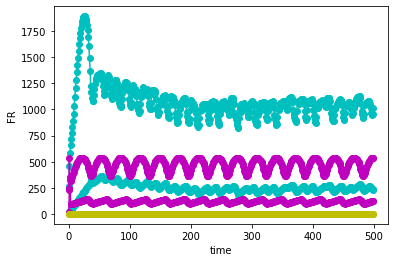

In [6]:
# RUN THE MODEL

import warnings

warnings.filterwarnings(
    "ignore",
    message=".*NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.*",
    category=DeprecationWarning
)

time_start =0
time_end = 500

time_tot = 500

time_axis = np.arange(time_start,time_end)

intensity =0
pulse_len= 10
silence_per=2 #2 - same length as pulse

stim_sig = create_stim_sig(intensity,pulse_len,silence_per)
data_rec_dic,dust_removed,energy_loss,model_excit_net,input_to_net = run_network(solution,time_tot,stim_sig=stim_sig,
                                        stim_13A = False,
                                        stim_SNs = True,
                                        record_data=True,
                                        display_movie=True) #DISPLAY MOVIE


A_vec_13A_rec_R = data_rec_dic["A_vec_13A_rec_R"]
A_vec_13A_rec_L = data_rec_dic["A_vec_13A_rec_L"]
A_vec_13B_rec_R = data_rec_dic["A_vec_13B_rec_R"]
A_vec_13B_rec_L = data_rec_dic["A_vec_13B_rec_L"]

HL_act_rec = data_rec_dic["HL_act_rec"]
MN_rec_L = data_rec_dic["MN_rec_L"]
MN_rec_R = data_rec_dic["MN_rec_R"]
SN_rec_L = data_rec_dic["SN_rec_L"]
SN_rec_R = data_rec_dic["SN_rec_R"]
out_excit_rec_L = data_rec_dic["out_excit_rec_L"] 
out_excit_rec_R = data_rec_dic["out_excit_rec_R"] 
out_excit_rec = data_rec_dic["out_excit_rec"] 
vel_rec =  data_rec_dic["vel_rec"]
angles_rec_L = data_rec_dic["angles_rec_L"] 
angles_rec_R = data_rec_dic["angles_rec_R"] 
joint_positions_XY_L_rec =  data_rec_dic["joint_positions_XY_L_rec"] 
joint_positions_XY_R_rec =  data_rec_dic["joint_positions_XY_R_rec"] 

W_mat_13A_L =  data_rec_dic["W_mat_13A_L"]
W_13A_MN_L = data_rec_dic["W_13A_MN_L"]
W_mat_SN_L = data_rec_dic["W_mat_SN_L"]
W_mat_SN_13A_L = data_rec_dic["W_mat_SN_13A_L"]
W_mat_SN_MNs_L = data_rec_dic["W_mat_SN_MNs_L"]
W_mat_13A_R =  data_rec_dic["W_mat_13A_R"]
W_13A_MN_R = data_rec_dic["W_13A_MN_R"]
W_mat_SN_R = data_rec_dic["W_mat_SN_R"]
W_mat_SN_13A_R = data_rec_dic["W_mat_SN_13A_R"]
W_mat_SN_MNs_R = data_rec_dic["W_mat_SN_MNs_R"]

W_sens_hidden = model_excit_net.W_sens_hidden
W_hidden = model_excit_net.W_hidden
W_hidden_out = model_excit_net.W_hidden_out


plt.plot(T(A_vec_13A_rec_L[0:6,time_start:time_end]),marker='o', color='c', linestyle='-')
plt.plot(T(A_vec_13A_rec_R[0:6,time_start:time_end]),marker='o', color='m', linestyle='-')


plt.plot(time_axis,T(stim_sig[0:6,time_start:time_end]*5),marker='o', color='y', linestyle='-')

plt.xlabel("time")
plt.ylabel("FR")

print(dust_removed)
print(energy_loss)

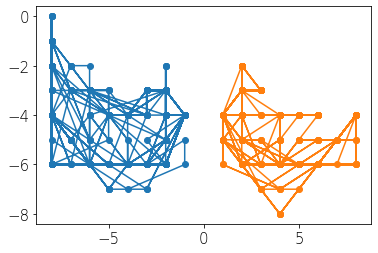

In [9]:
plt.plot(joint_positions_XY_L_rec[0,1,:],joint_positions_XY_L_rec[0,0,:],'-o')
plt.plot(joint_positions_XY_R_rec[0,1,:],joint_positions_XY_R_rec[0,0,:],'-o')

Text(0.5, 0, 'time')

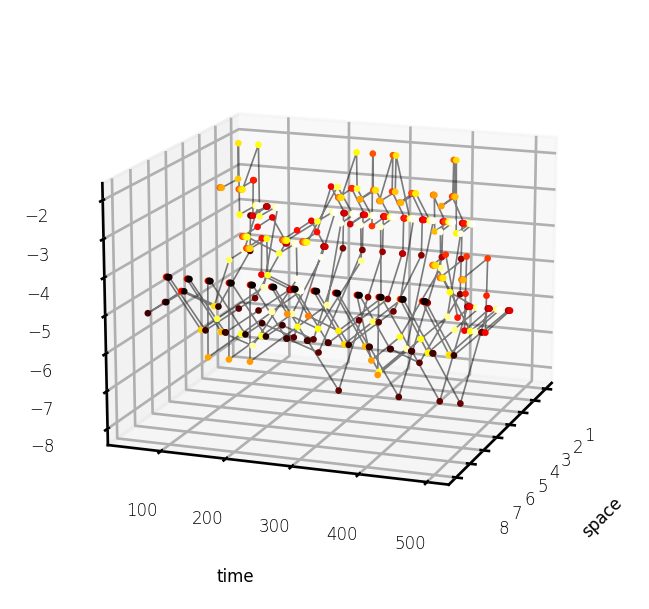

In [10]:

fig = plt.figure(figsize=(9, 3), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 5}
matplotlib.rc('font', **font)

time_start =50
time_end = 500

time_axis = np.arange(time_start,time_end)

ax = plt.axes(projection='3d')

xdata=joint_positions_XY_L_rec[0,1,time_start:time_end]
zdata=joint_positions_XY_L_rec[0,0,time_start:time_end]
ydata=time_axis
col=T(A_vec_13A_rec_L[0,time_start:time_end])/np.max(np.max(T(A_vec_13A_rec_L[0,time_start:time_end])))

#ax.scatter3D(xdata, ydata, zdata, 'o', c=col, s=1, cmap='hot',alpha=1)
#ax.plot(xdata, ydata, zdata,'k-',linewidth=0.5,alpha=0.5)

xdata=joint_positions_XY_R_rec[0,1,time_start:time_end]
zdata=joint_positions_XY_R_rec[0,0,time_start:time_end]
ydata=time_axis
col=T(A_vec_13A_rec_R[1,time_start:time_end])/np.max(np.max(T(A_vec_13A_rec_R[1,time_start:time_end])))

ax.scatter3D(xdata, ydata, zdata, 'o', c=col, s=1, cmap='hot',alpha=1)
ax.plot(xdata, ydata, zdata,'k-',linewidth=0.5,alpha=0.5)

ax.view_init(15, 20)

plt.xlabel("space")
#plt.zlabel("space")
plt.ylabel("time")

C:\Users\ravbar\AppData\Local\Temp/ipykernel_33348/2491433402.py:23: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_33348/2491433402.py:45: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_33348/2491433402.py:66: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_33348/2491433402.py:81: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))


Text(0, 0.5, 'angle [°]')

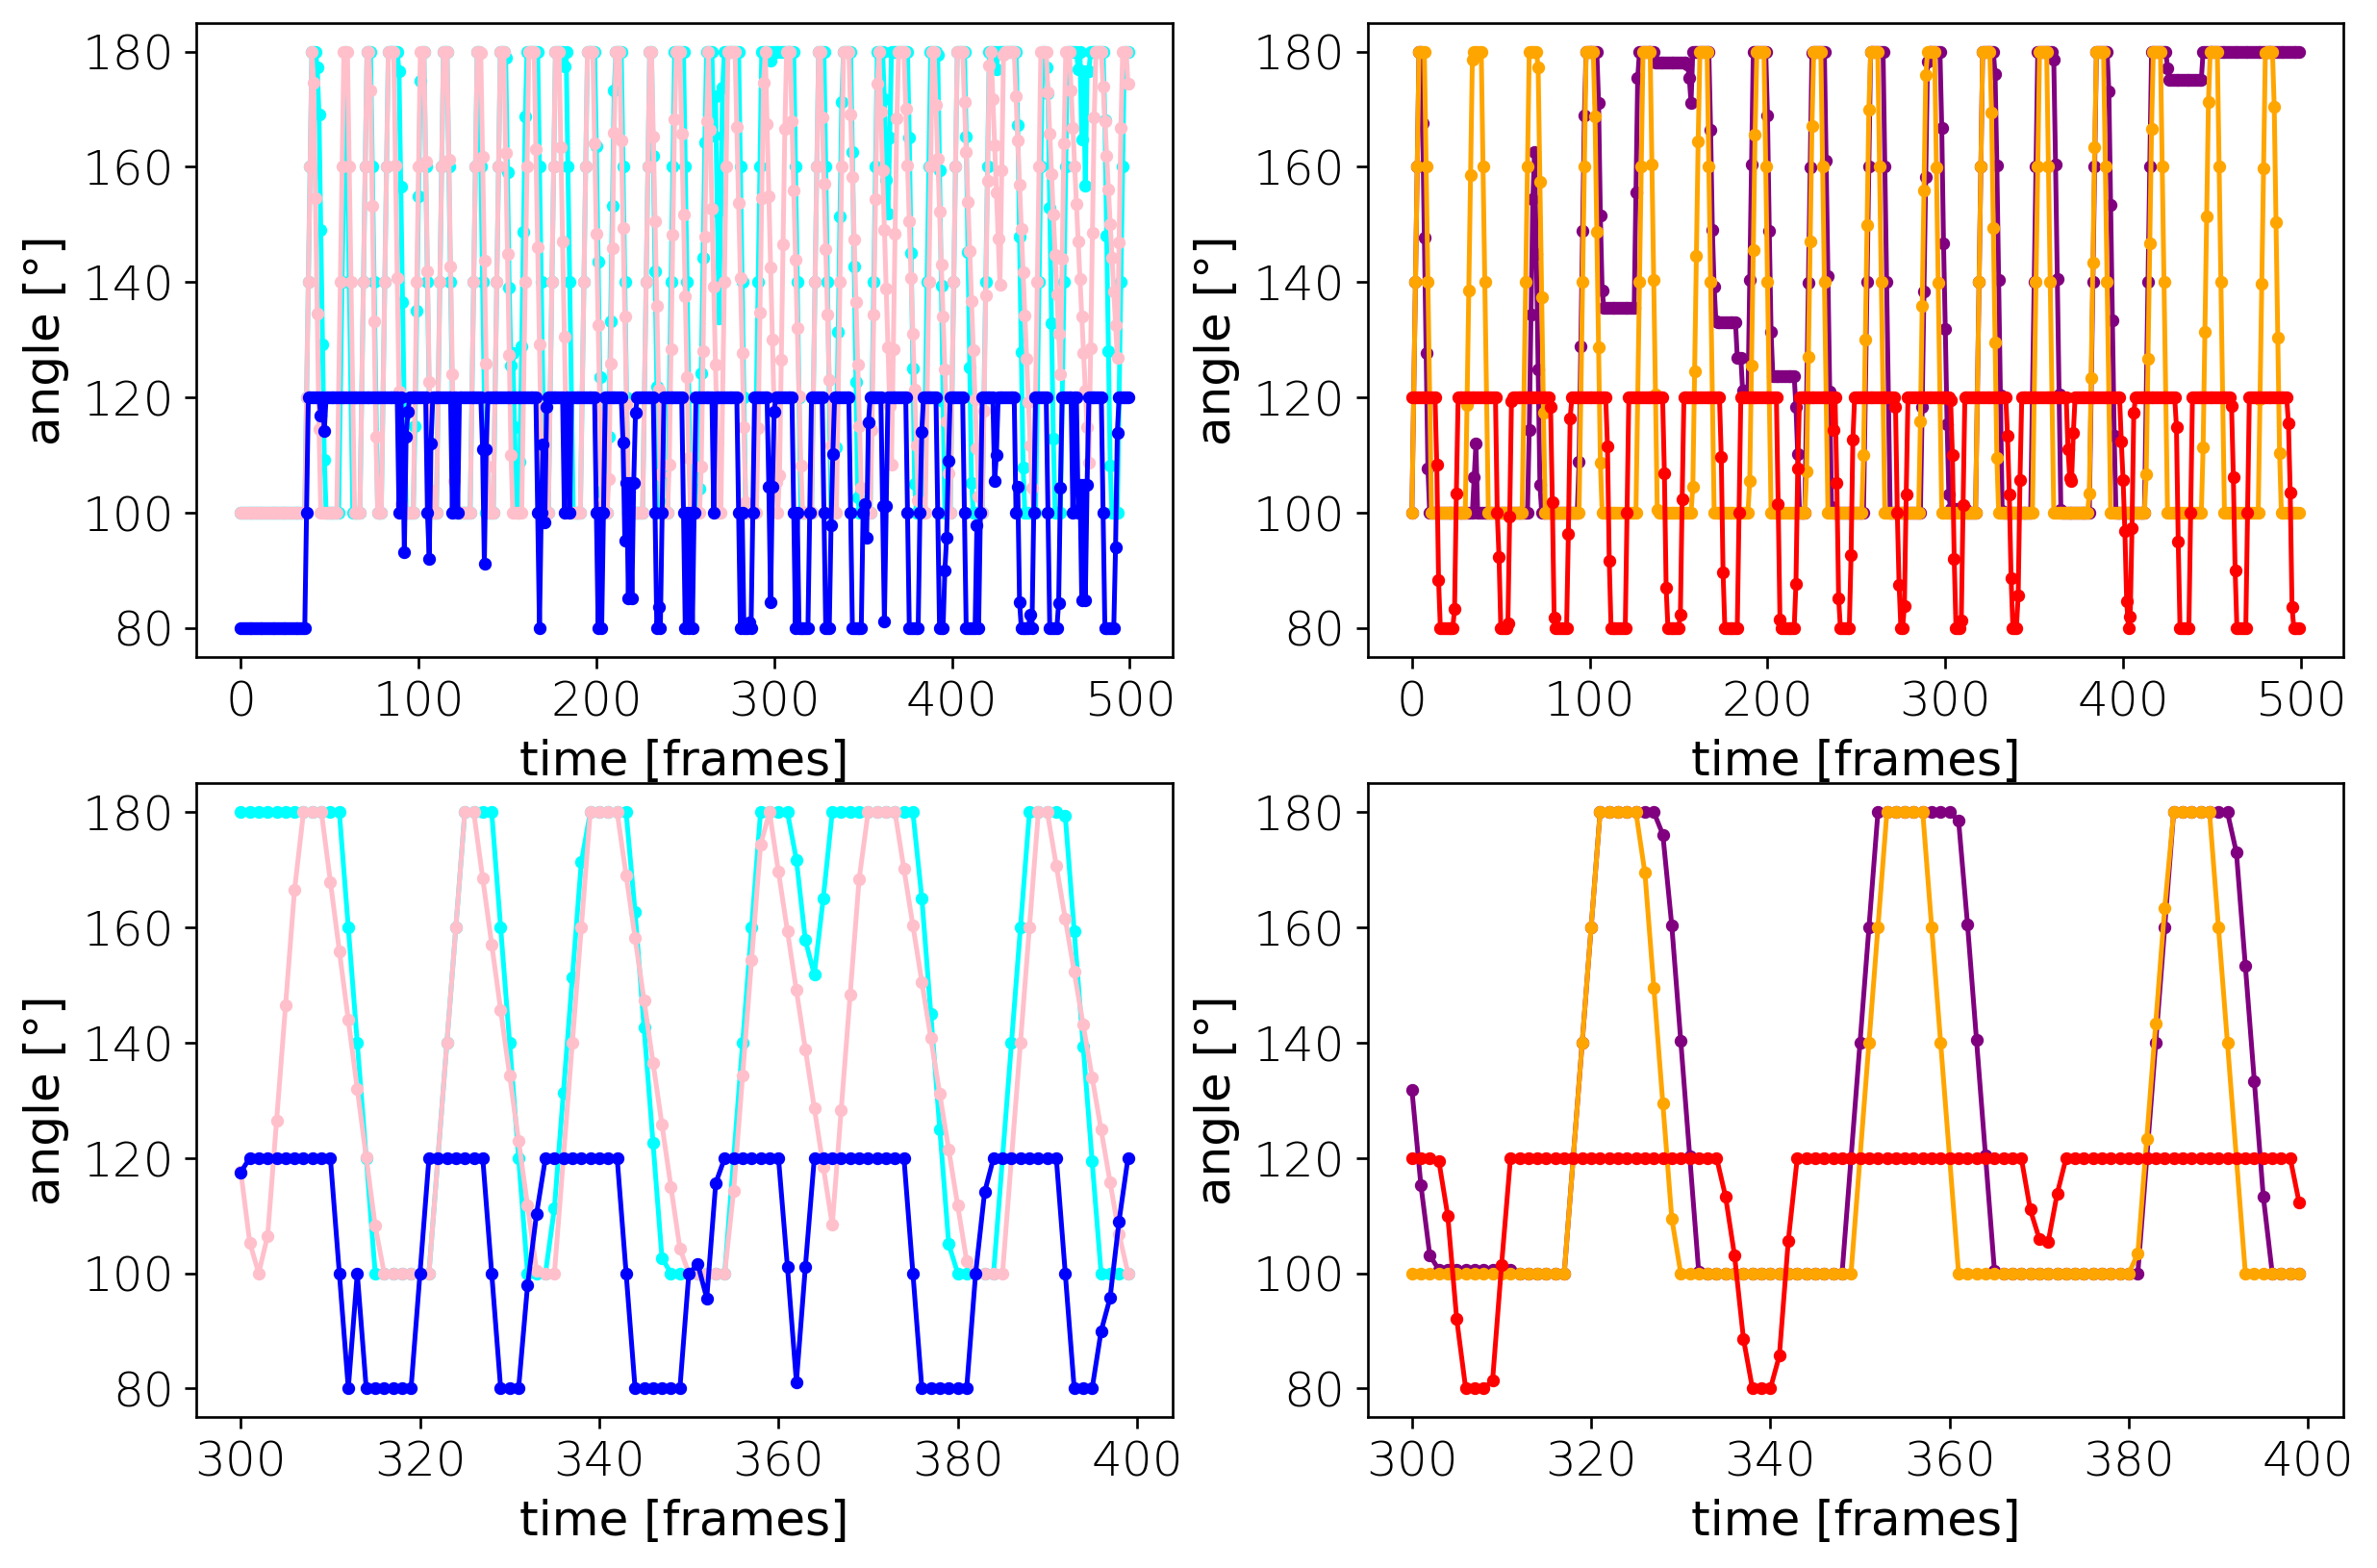

In [14]:

fig = plt.figure(figsize=(12, 8), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 15}
matplotlib.rc('font', **font)


time_start = 0
time_end = 500

time_axis = np.arange(time_start,time_end)

stim_on = True

plt.subplot(2,2,1)  

plt.plot(time_axis,T(angles_rec_L[0,time_start:time_end]),marker='.', color='cyan', linestyle='-')
plt.plot(time_axis,T(angles_rec_L[1,time_start:time_end]),marker='.', color='pink', linestyle='-')
plt.plot(time_axis,T(angles_rec_L[2,time_start:time_end]),marker='.', color='b', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)*10+np.min(np.min(angles_rec_L))
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

#plt.xlabel("time")
#plt.ylabel("angle")


plt.xlabel("time [frames]")
plt.ylabel("angle [°]")




plt.subplot(2,2,2)  

plt.plot(time_axis,T(angles_rec_R[0,time_start:time_end]),marker='.', color='purple', linestyle='-')
plt.plot(time_axis,T(angles_rec_R[1,time_start:time_end]),marker='.', color='orange', linestyle='-')
plt.plot(time_axis,T(angles_rec_R[2,time_start:time_end]),marker='.', color='r', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)*10+np.min(np.min(angles_rec_L))
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time [frames]")
plt.ylabel("angle [°]")


plt.subplot(2,2,3)  

time_start = 300
time_end = 400

time_axis = np.arange(time_start,time_end)

plt.plot(time_axis,T(angles_rec_L[0,time_start:time_end]),marker='.', color='cyan', linestyle='-')
plt.plot(time_axis,T(angles_rec_L[1,time_start:time_end]),marker='.', color='pink', linestyle='-')
plt.plot(time_axis,T(angles_rec_L[2,time_start:time_end]),marker='.', color='b', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)*10+np.min(np.min(angles_rec_L))
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time [frames]")
plt.ylabel("angle [°]")

plt.subplot(2,2,4)  

plt.plot(time_axis,T(angles_rec_R[0,time_start:time_end]),marker='.', color='purple', linestyle='-')
plt.plot(time_axis,T(angles_rec_R[1,time_start:time_end]),marker='.', color='orange', linestyle='-')
plt.plot(time_axis,T(angles_rec_R[2,time_start:time_end]),marker='.', color='r', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)*10+np.min(np.min(angles_rec_L))
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time [frames]")
plt.ylabel("angle [°]")

C:\Users\ravbar\AppData\Local\Temp/ipykernel_33348/1042380946.py:24: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_33348/1042380946.py:40: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_33348/1042380946.py:61: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))
C:\Users\ravbar\AppData\Local\Temp/ipykernel_33348/1042380946.py:76: RuntimeWarning: invalid value encountered in true_divide
  stim_plt = stim_plt/np.max(np.max(stim_plt))


Text(0, 0.5, 'angular velocity [°/frame]')

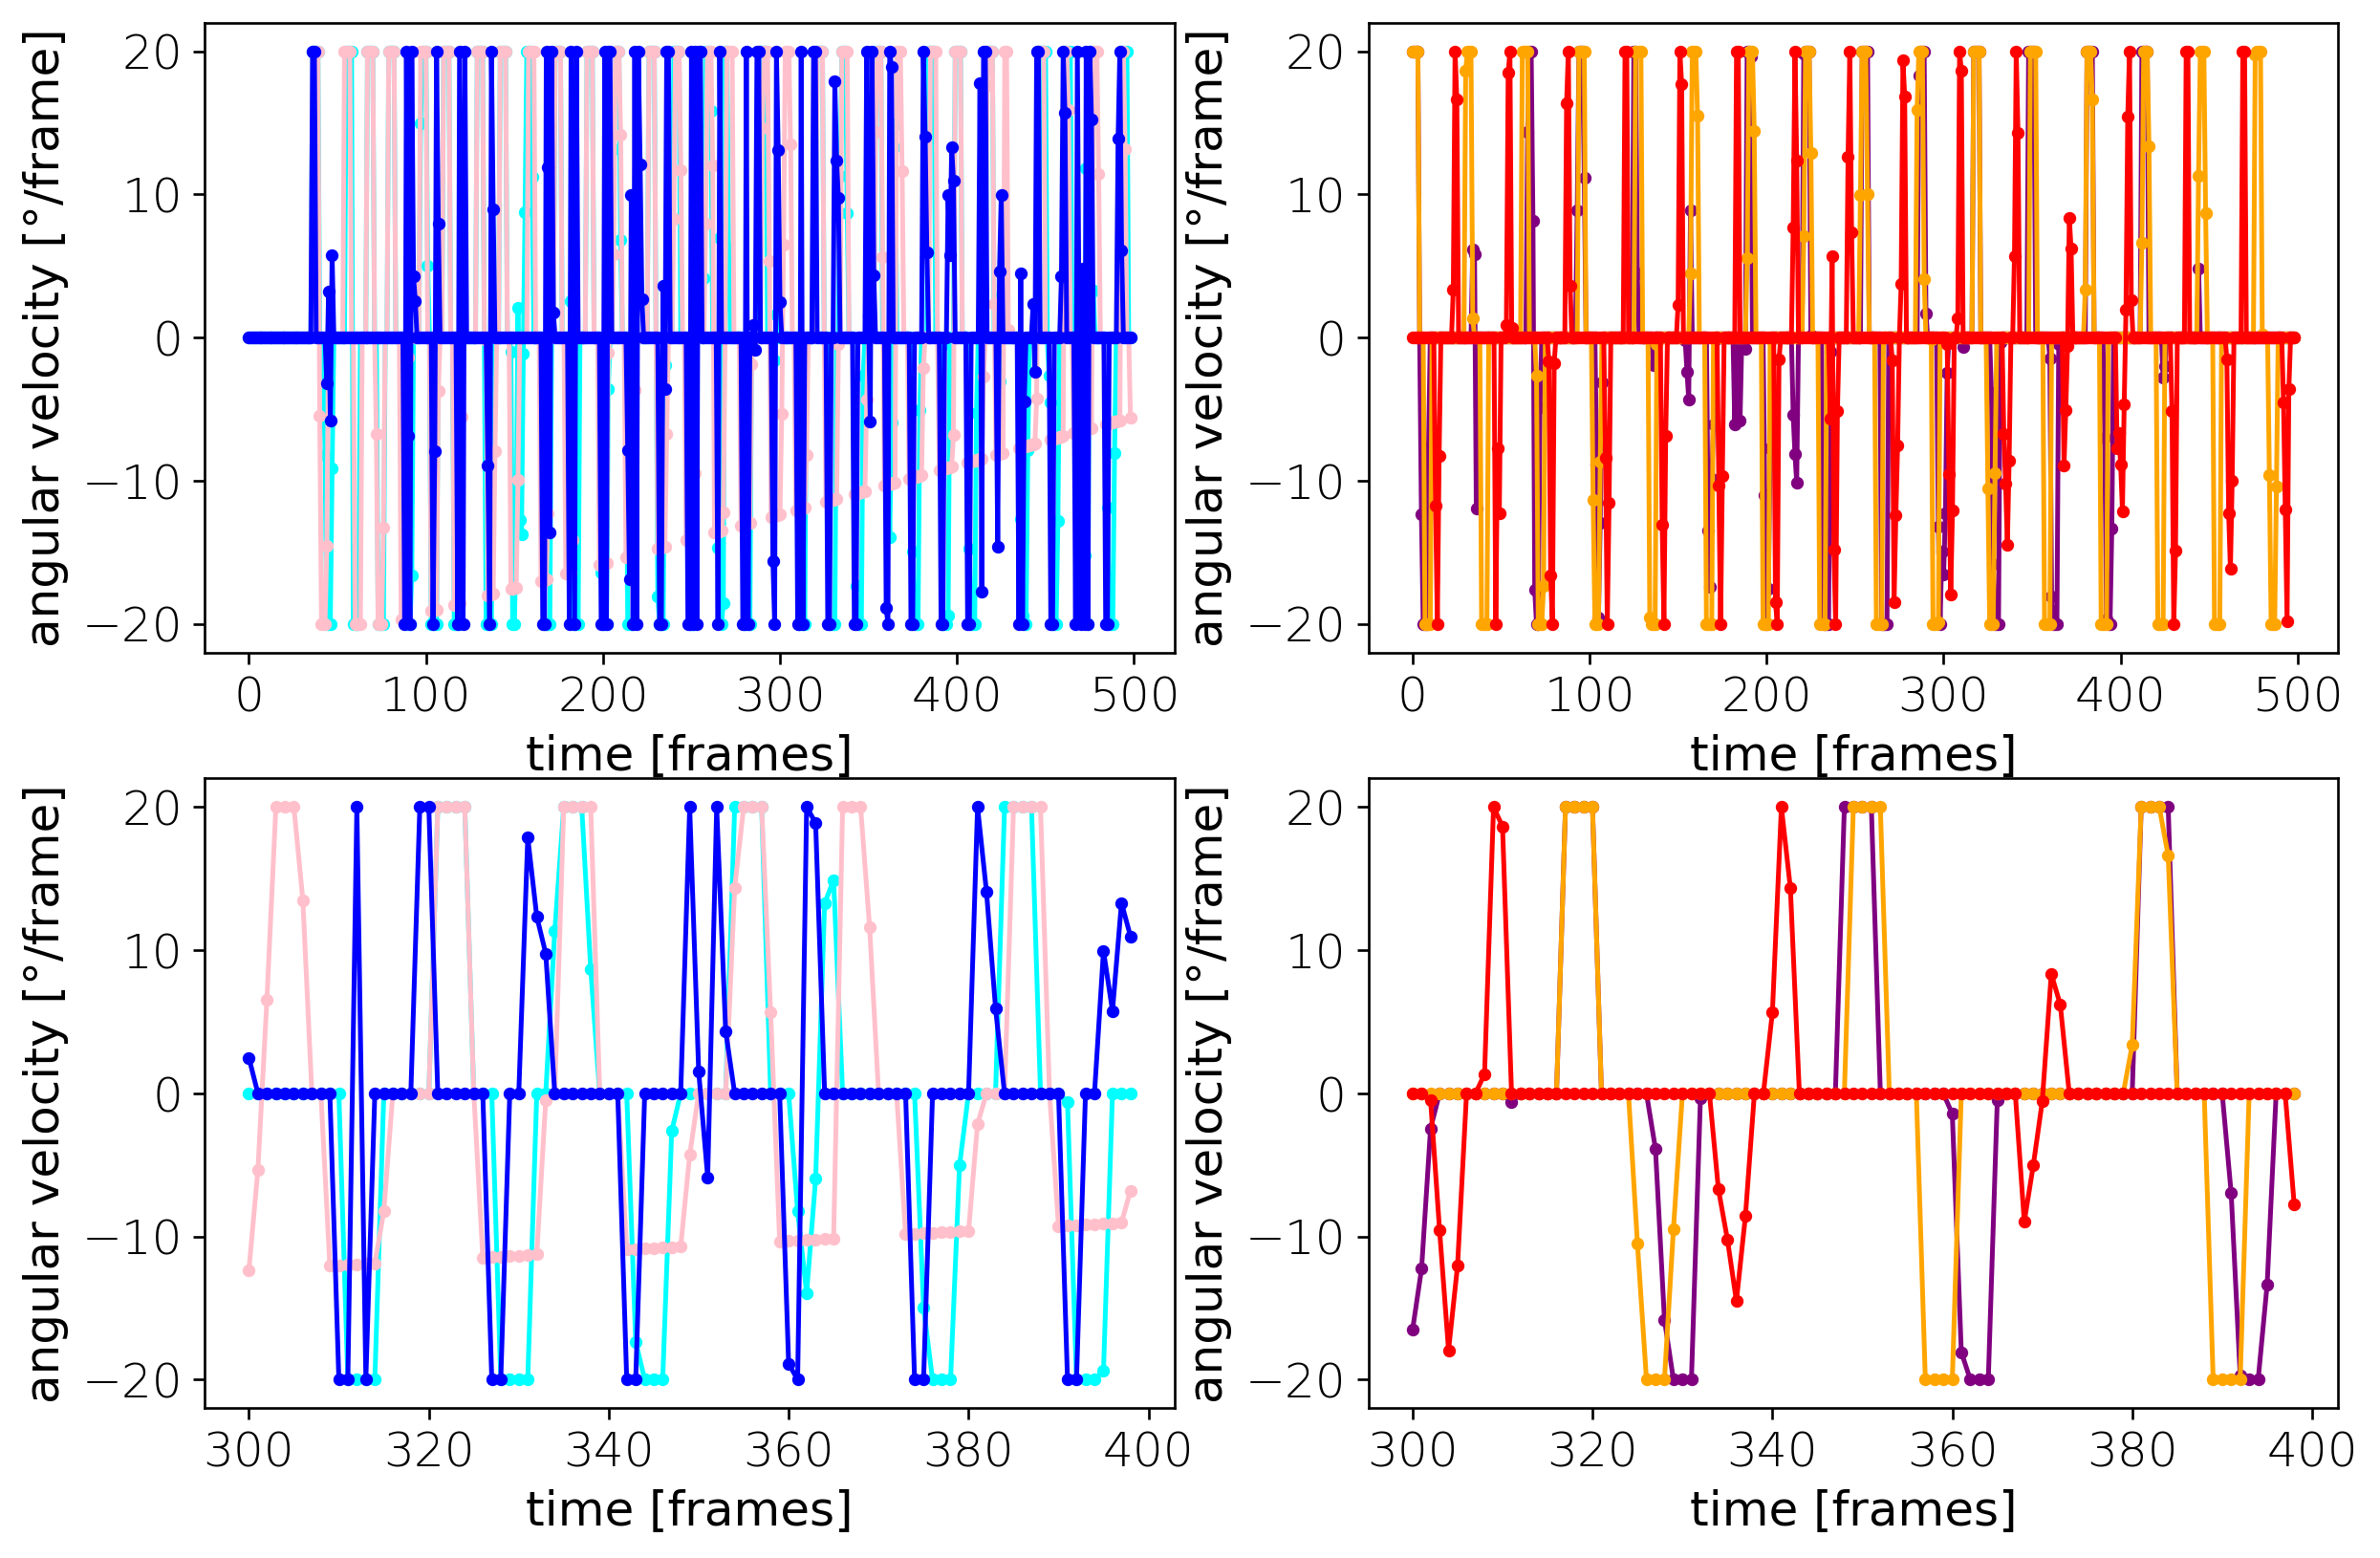

In [15]:

fig = plt.figure(figsize=(12, 8), dpi=240)
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 15}
matplotlib.rc('font', **font)


time_start = 0
time_end = 500

time_axis = np.arange(time_start,time_end-1)

stim_on = True


plt.subplot(2,2,1)  

plt.plot(time_axis,T(np.diff(angles_rec_L[0,time_start:time_end])),marker='.', color='cyan', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_L[1,time_start:time_end])),marker='.', color='pink', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_L[2,time_start:time_end])),marker='.', color='b', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end-1]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time [frames]")
plt.ylabel("angular velocity [°/frame]")


plt.subplot(2,2,2)  

plt.plot(time_axis,T(np.diff(angles_rec_R[0,time_start:time_end])),marker='.', color='purple', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_R[1,time_start:time_end])),marker='.', color='orange', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_R[2,time_start:time_end])),marker='.', color='r', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end-1]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time [frames]")
plt.ylabel("angular velocity [°/frame]")


plt.subplot(2,2,3)  

time_start = 300
time_end = 400

time_axis = np.arange(time_start,time_end-1)

plt.plot(time_axis,T(np.diff(angles_rec_L[0,time_start:time_end])),marker='.', color='cyan', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_L[1,time_start:time_end])),marker='.', color='pink', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_L[2,time_start:time_end])),marker='.', color='b', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end-1]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time [frames]")
plt.ylabel("angular velocity [°/frame]")

plt.subplot(2,2,4)  

plt.plot(time_axis,T(np.diff(angles_rec_R[0,time_start:time_end])),marker='.', color='purple', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_R[1,time_start:time_end])),marker='.', color='orange', linestyle='-')
plt.plot(time_axis,T(np.diff(angles_rec_R[2,time_start:time_end])),marker='.', color='r', linestyle='-')

if stim_on == True:
    stim_plt = stim_sig[:,time_start:time_end-1]
    stim_plt = stim_plt/np.max(np.max(stim_plt))
    stim_plt = np.squeeze(stim_plt,axis=0)
    plt.plot(time_axis,stim_plt,marker='o', color='y', linestyle='-')

plt.xlabel("time [frames]")
plt.ylabel("angular velocity [°/frame]")

Text(0.73, 0.9, 'Right leg')

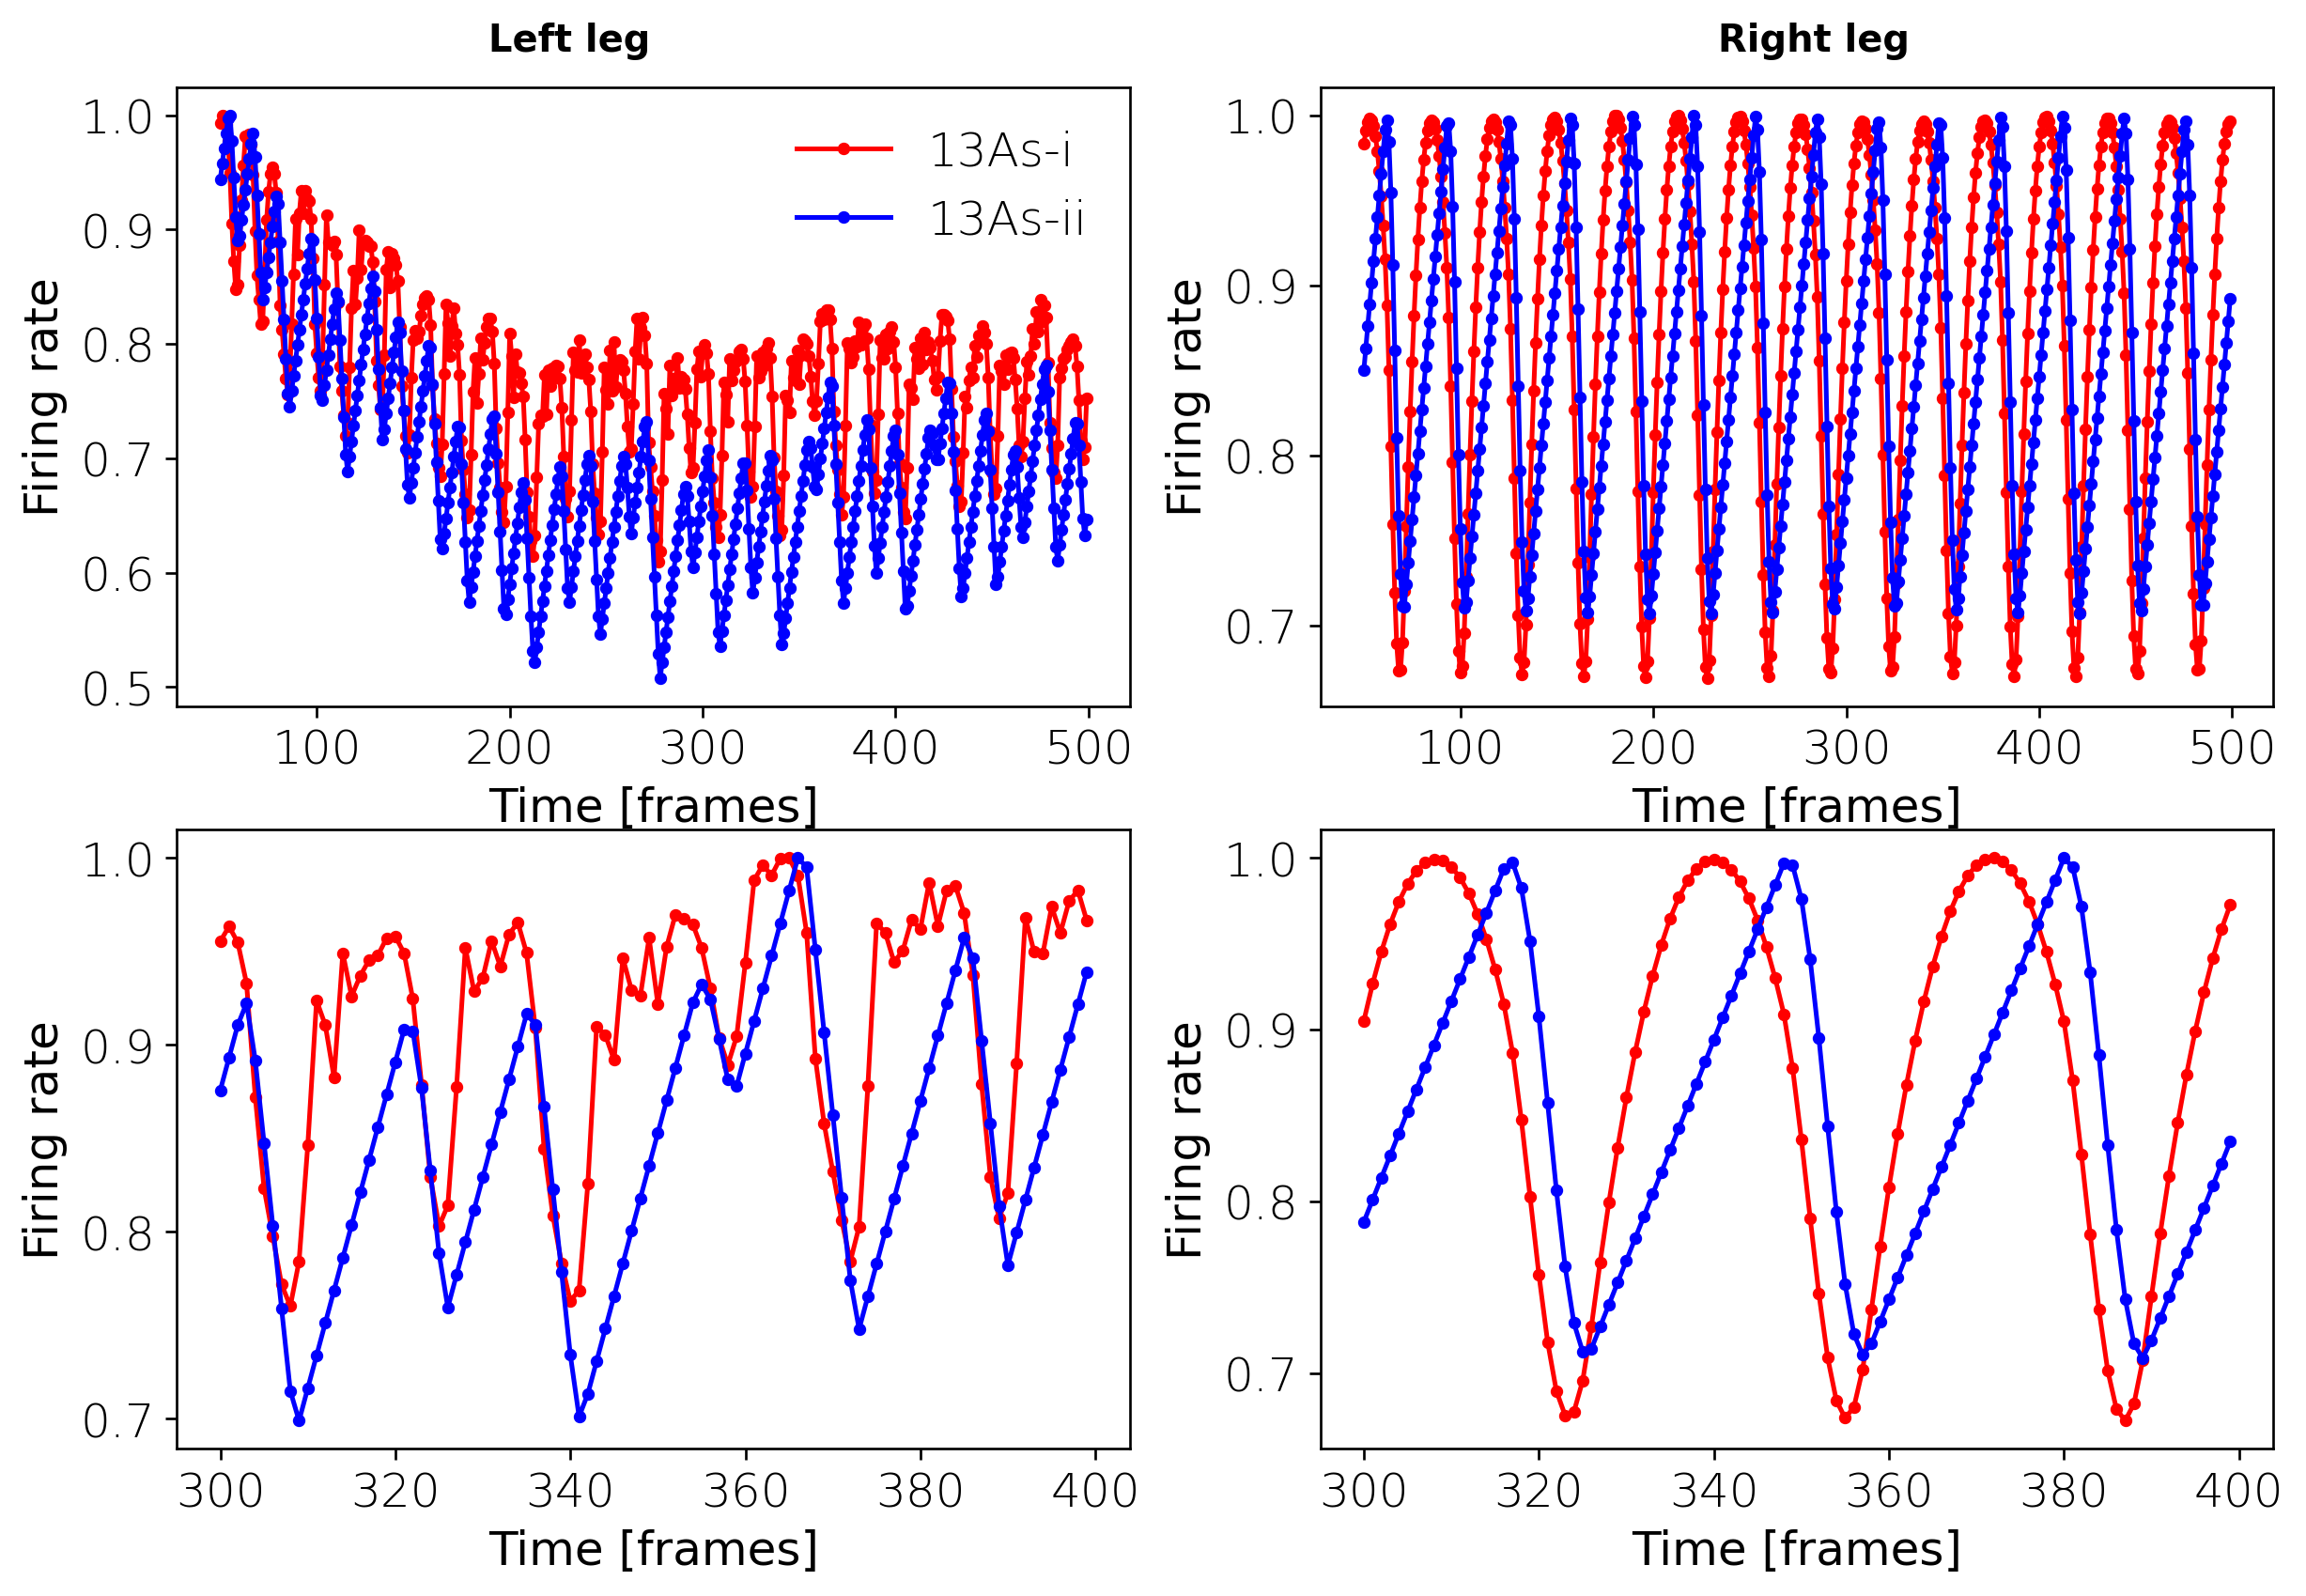

In [18]:
fig = plt.figure(figsize=(12, 8), dpi=240)
font = {'family': 'sans-serif',
        'weight': 'light',
        'size': 15}
matplotlib.rc('font', **font)

stim_on = False

# ==== First panel ====
plt.subplot(2, 2, 1)
time_start = 50
time_end = 500
time_axis = np.arange(time_start, time_end)

feat1 = T(A_vec_13A_rec_L[0, time_start:time_end])
feat2 = T(A_vec_13A_rec_L[1, time_start:time_end])

feat1 = feat1 / np.max(np.max(feat1))
feat2 = feat2 / np.max(np.max(feat2))

plt.plot(time_axis, feat1, marker='.', color='r', linestyle='-', label="13As-i")
plt.plot(time_axis, feat2, marker='.', color='b', linestyle='-', label="13As-ii")

if stim_on:
    plt.plot(time_axis, T(stim_sig[0:6, time_start:time_end] / 100 + 0.8),
             marker='o', color='y', linestyle='-')

plt.xlabel("Time [frames]")
plt.ylabel("Firing rate")
plt.legend(frameon=False)

# ==== Second panel ====
plt.subplot(2, 2, 2)
feat1 = T(A_vec_13A_rec_R[0, time_start:time_end])
feat2 = T(A_vec_13A_rec_R[1, time_start:time_end])

feat1 = feat1 / np.max(np.max(feat1))
feat2 = feat2 / np.max(np.max(feat2))

plt.plot(time_axis, feat1, marker='.', color='r', linestyle='-')
plt.plot(time_axis, feat2, marker='.', color='b', linestyle='-')

if stim_on:
    plt.plot(time_axis, T(stim_sig[0:6, time_start:time_end] / 100 + 0.8),
             marker='o', color='y', linestyle='-')

plt.xlabel("Time [frames]")
plt.ylabel("Firing rate")

# ==== Third panel ====
plt.subplot(2, 2, 3)
time_start = 300
time_end = 400
time_axis = np.arange(time_start, time_end)

feat1 = T(A_vec_13A_rec_L[0, time_start:time_end])
feat2 = T(A_vec_13A_rec_L[1, time_start:time_end])

feat1 = feat1 / np.max(np.max(feat1))
feat2 = feat2 / np.max(np.max(feat2))

plt.plot(time_axis, feat1, marker='.', color='r', linestyle='-')
plt.plot(time_axis, feat2, marker='.', color='b', linestyle='-')

if stim_on:
    plt.plot(time_axis, T(stim_sig[0:6, time_start:time_end] / 100 + 0.8),
             marker='o', color='y', linestyle='-')

plt.xlabel("Time [frames]")
plt.ylabel("Firing rate")

# ==== Fourth panel ====
plt.subplot(2, 2, 4)
feat1 = T(A_vec_13A_rec_R[0, time_start:time_end])
feat2 = T(A_vec_13A_rec_R[1, time_start:time_end])

feat1 = feat1 / np.max(np.max(feat1))
feat2 = feat2 / np.max(np.max(feat2))

plt.plot(time_axis, feat1, marker='.', color='r', linestyle='-')
plt.plot(time_axis, feat2, marker='.', color='b', linestyle='-')

if stim_on:
    plt.plot(time_axis, T(stim_sig[0:6, time_start:time_end] / 100 + 0.8),
             marker='o', color='y', linestyle='-')

plt.xlabel("Time [frames]")
plt.ylabel("Firing rate")

# ==== Column headers ====
fig.text(0.27, 0.90, "Left leg", ha='center', fontsize=12, weight='bold')
fig.text(0.73, 0.90, "Right leg", ha='center', fontsize=12, weight='bold')

In [19]:

#create pulses of various lengths - ep_range

time_start =50
time_end = 500

time_tot =500

left_leg =True

ep_range = [2,100] #pulse length range
feat_cube = np.zeros((ep_range[1],time_tot,23))
mean_feat_rec = np.zeros((ep_range[1],23))

raster_13A_0_L = np.zeros((ep_range[1],time_end-time_start))
raster_13A_1_L = np.zeros((ep_range[1],time_end-time_start))

freq_spect_rec = np.zeros((ep_range[1],time_end-time_start))
#freq_spect_rec = np.zeros((ep_range[1],50))


for e_p in range(ep_range[0],ep_range[1]):
    
    # define stimulation intensity (0 = no stim) (10 used in the MS)
    intensity = 0    
    #intensity =  e_p/10
    #intensity =  10
    #intensity =  5
    
    pulse_len=e_p
    #pulse_len=5
    
    silence_per=2 #2 - same length as pulse

    stim_sig = create_stim_sig(intensity,pulse_len,silence_per)


    data_rec_dic,dust_removed,energy_loss,model_excit_net,input_to_net = run_network(solution,time_tot,stim_sig=stim_sig,
                                            stim_13A = False,
                                            stim_SNs = True,
                                            record_data=True,
                                            display_movie=False)


    A_vec_13A_rec_R = data_rec_dic["A_vec_13A_rec_R"]
    A_vec_13A_rec_L = data_rec_dic["A_vec_13A_rec_L"]
    HL_act_rec = data_rec_dic["HL_act_rec"]
    MN_rec_L = data_rec_dic["MN_rec_L"]
    MN_rec_R = data_rec_dic["MN_rec_R"]
    SN_rec_L = data_rec_dic["SN_rec_L"]
    SN_rec_R = data_rec_dic["SN_rec_R"]
    out_excit_rec_L = data_rec_dic["out_excit_rec_L"] 
    out_excit_rec_R = data_rec_dic["out_excit_rec_R"] 
    vel_rec =  data_rec_dic["vel_rec"]
    angles_rec_L = data_rec_dic["angles_rec_L"] 
    angles_rec_R = data_rec_dic["angles_rec_R"] 

    if left_leg == True:
    
        feat_cube[e_p,:,0] = stim_sig
        feat_cube[e_p,:,1:4] = T(angles_rec_L)
        feat_cube[e_p,:,4:7] = T(np.hstack((np.diff(angles_rec_L),np.zeros((3,1)) )) ) 
        feat_cube[e_p,:,7:9] = T(A_vec_13A_rec_L)/np.max(np.max(A_vec_13A_rec_L))
        feat_cube[e_p,:,9:15] = T(MN_rec_L)
        
        raster_13A_0_L[e_p,:] = A_vec_13A_rec_L[0,time_start:time_end]
        raster_13A_1_L[e_p,:] = A_vec_13A_rec_L[1,time_start:time_end]
    
    if left_leg == False:
    
        feat_cube[e_p,:,0] = stim_sig
        feat_cube[e_p,:,1:4] = T(angles_rec_R)
        feat_cube[e_p,:,4:7] = T(np.hstack((np.diff(angles_rec_R),np.zeros((3,1)) )) ) 
        feat_cube[e_p,:,7:9] = T(A_vec_13A_rec_R)/np.max(np.max(A_vec_13A_rec_R))
        feat_cube[e_p,:,9:15] = T(MN_rec_R)
    
    #sig=T(angles_rec_L[0,:])
    #sig=feat_cube[e_p,:,6] #prox ang. vel
    sig=feat_cube[e_p,:,4] #distal ang. vel
    #sig=feat_cube[e_p,:,0] #stim sig
    sig = scipy.ndimage.filters.gaussian_filter(T(np.expand_dims(sig,axis=1)), [0, 0], order=0, mode='constant')
    #ft = np.absolute(np.fft.fft(sig,time_end-time_start))
    ft = np.absolute(np.fft.fft(sig,time_end-time_start))
    ft = ft/np.max(ft)
    #ft = scipy.ndimage.filters.gaussian_filter(T(np.expand_dims(ft,axis=1)), [0, 0], order=0, mode='constant')
    ft = scipy.ndimage.filters.gaussian_filter(ft, [0, 0], order=0, mode='constant')
    max_pow_freq = np.argmax(ft[0,10:250]==np.max(ft[0,10:250]))
    freq_spect_rec[e_p,:]=ft 
    
    mean_feat_rec[e_p,1] = max_pow_freq 
    mean_feat_rec[e_p,2] = np.mean(vel_rec[0,:])
    
    print(e_p)



2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<Figure size 2880x1920 with 0 Axes>

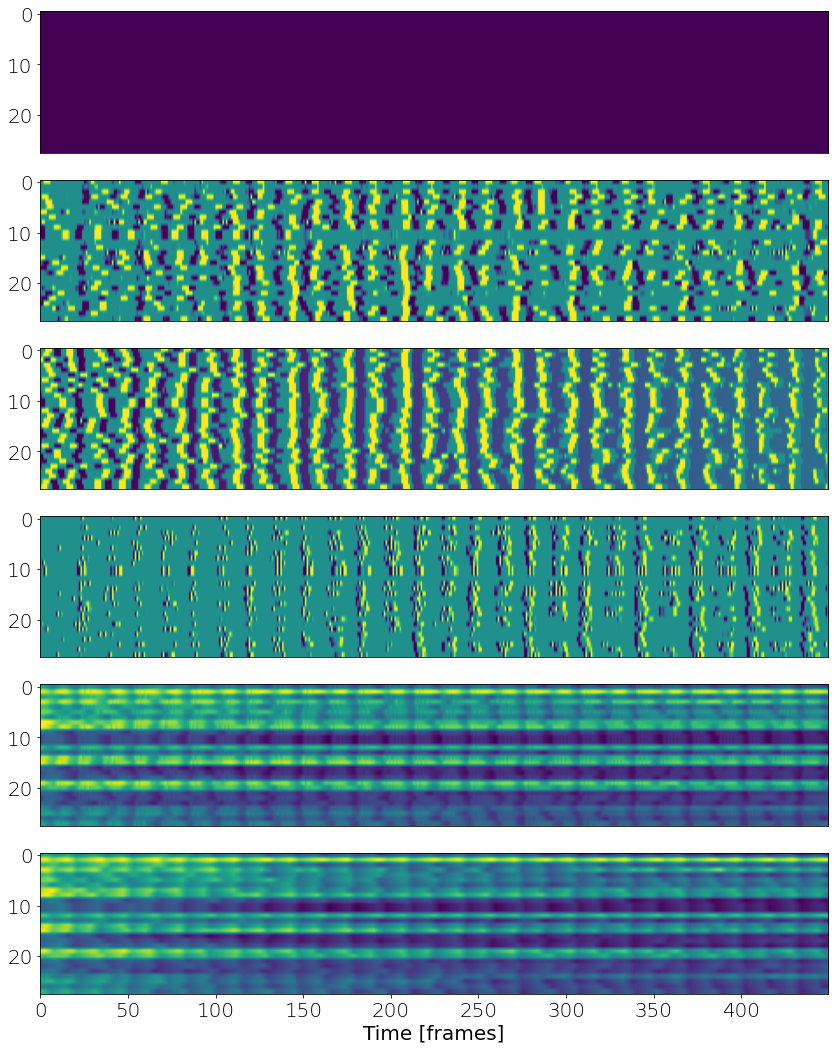

In [20]:
fig = plt.figure(figsize=(12, 8), dpi=240)
font = {'family': 'sans-serif', 'weight': 'light', 'size': 20}
matplotlib.rc('font', **font)

ex_start = 2
ex_end = 30
time_start = 50
time_end = 500

plot_feat_ind = [0, 4, 5, 6, 7, 8]
fig, axs = plt.subplots(6, 1, figsize=(12, 15), sharex=True)

for i in range(6):
    ind = plot_feat_ind[i]
    axs[i].imshow(feat_cube[ex_start:ex_end, time_start:time_end, ind], aspect='auto')

    if i < 5:
        axs[i].tick_params(labelbottom=False, bottom=False)  # hide ticks and labels
    else:
        axs[i].set_xlabel('Time [frames]')
        axs[i].tick_params(bottom=True, labelbottom=True)    # show only on bottom panel

plt.tight_layout()
plt.show()

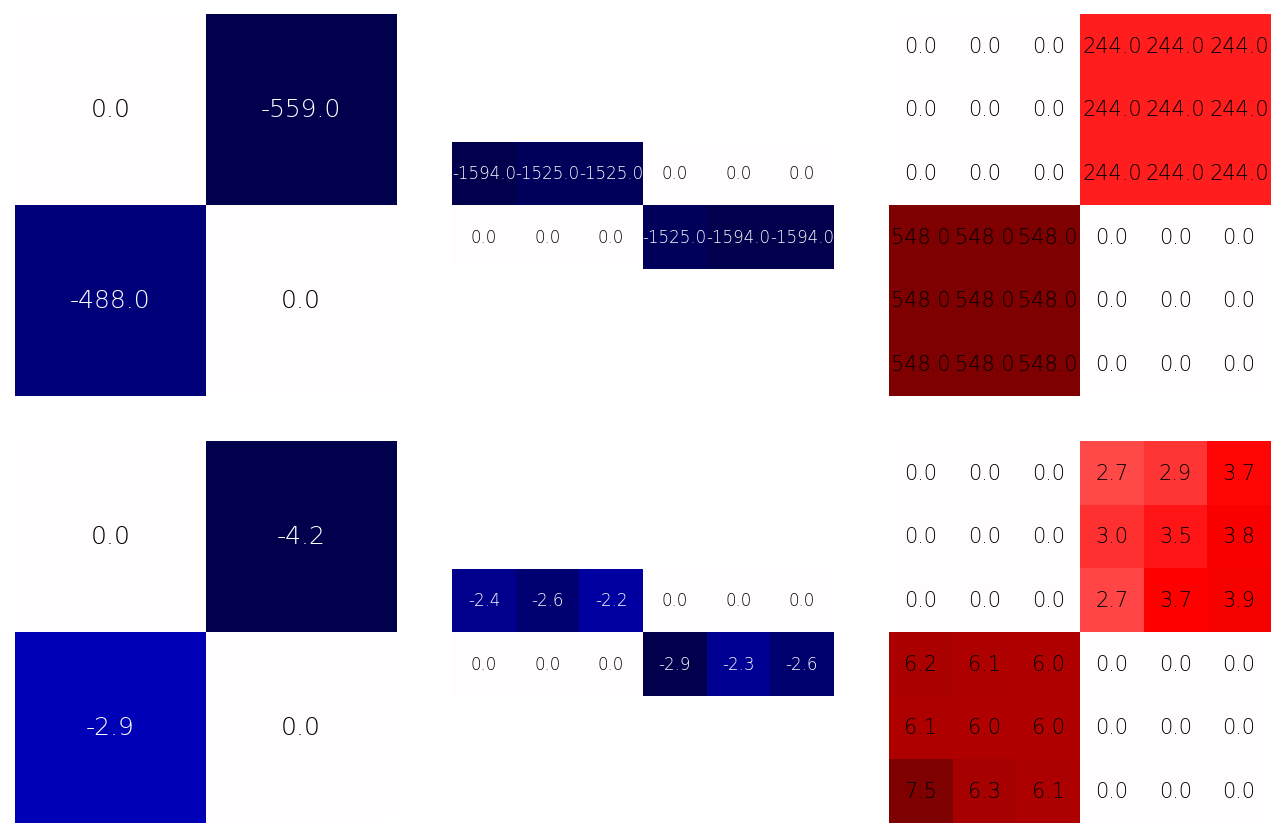

In [22]:

def draw_matrix(matrix, text_size, ax):
    vmax = np.max(np.abs(matrix))
    ax.imshow(matrix, cmap='seismic', interpolation='nearest', vmin=-vmax, vmax=vmax)

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i][j]
            val_rounded = round(val, 1)
            text_color = 'white' if val < -0.5 * vmax else 'black'
            ax.text(j, i, f"{val_rounded:.1f}", ha='center', va='center',
                    color=text_color, fontsize=text_size)

    ax.axis('off')
    
    
W_mat_13A_freeze = np.zeros((2,2))
W_mat_13B_freeze = np.zeros((2,1))
W_13A_MN_freeze = np.zeros((2,6))
#W_mat_SN_freeze = np.zeros((6,1))
W_mat_SN_13A_freeze = np.zeros((6,2))
W_mat_SN_MNs_freeze = np.zeros((6,6))

#W_mat_13A_freeze[0,1]=-64
#W_mat_13A_freeze[1,0]=-82
W_mat_13A_freeze[0,1]=-559
W_mat_13A_freeze[1,0]=-488

W_mat_13B_freeze[0,0]=-413
W_mat_13B_freeze[1,0]=-160

# W_13A_MN_freeze[0,1:3] = -488
# W_13A_MN_freeze[1,4:6] = -612
# W_13A_MN_freeze[0,0] = -612
# W_13A_MN_freeze[1,3] = -488

W_13A_MN_freeze[0,1:3] = -1525
W_13A_MN_freeze[1,4:6] = -1594
W_13A_MN_freeze[0,0] = -1594
W_13A_MN_freeze[1,3] = -1525

W_mat_SN_13A_freeze[0:3,0] = 526
W_mat_SN_13A_freeze[3:6,0] = 153
W_mat_SN_13A_freeze[3:6,1] = 48

W_mat_SN_MNs_freeze[0:3,3:6] = 244
W_mat_SN_MNs_freeze[3:6,0:3] = 548        

# === Matrices ===
top_matrices = [
    (W_mat_13A_freeze, 12),
    #(W_mat_13B_freeze, 12),
    (W_13A_MN_freeze, 8),
    #(W_mat_SN_13A_freeze, 10),
    (W_mat_SN_MNs_freeze, 10),
]

bottom_matrices = [
    (W_mat_13A_L, 12),
    (W_13A_MN_L, 8),
    (W_mat_SN_MNs_L, 10),
]

# === Plot ===
n_cols = max(len(top_matrices), len(bottom_matrices))
fig, axs = plt.subplots(2, n_cols, figsize=(3 * n_cols, 6), dpi=150)

for i, (matrix, size) in enumerate(top_matrices):
    draw_matrix(matrix, size, axs[0, i])

for i, (matrix, size) in enumerate(bottom_matrices):
    draw_matrix(matrix, size, axs[1, i])

# Hide any unused axes
for ax in axs.flat:
    if not ax.has_data():
        ax.axis('off')

plt.tight_layout()
plt.show()

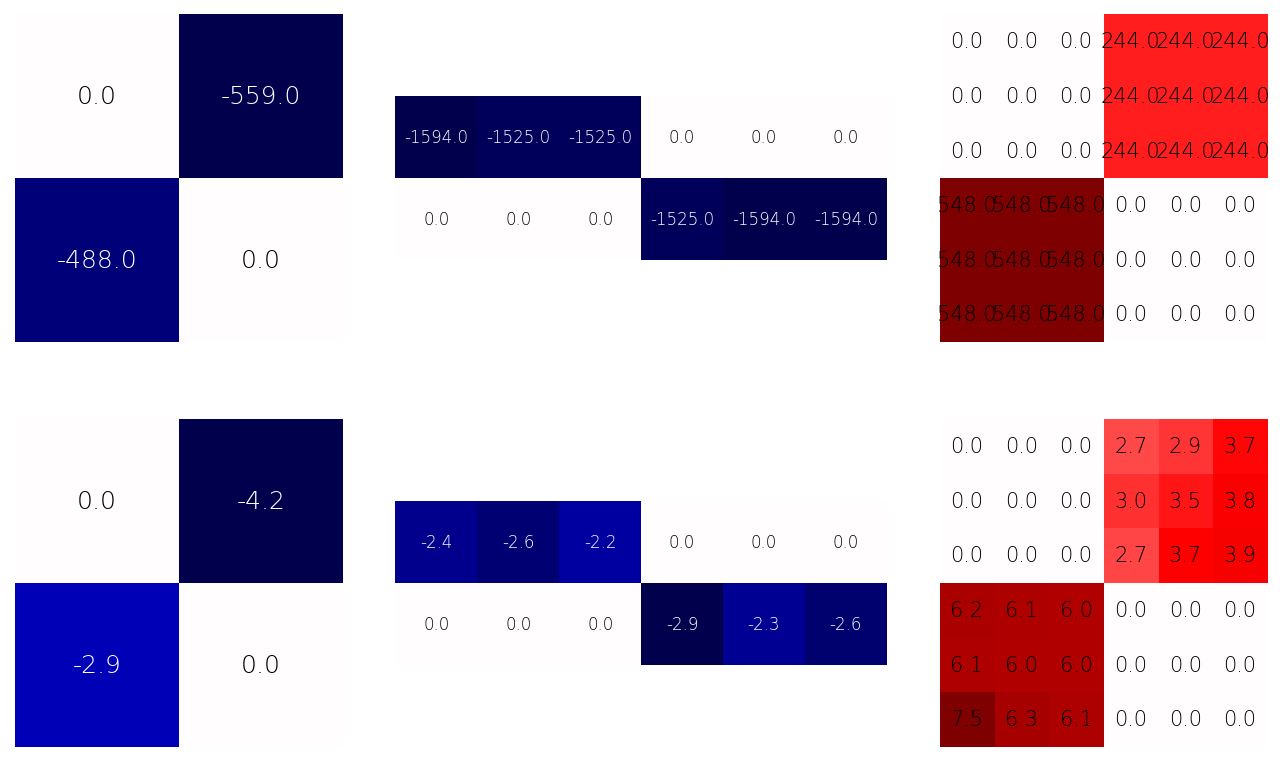

In [23]:
# === Plot with bigger middle matrices ===
n_cols = max(len(top_matrices), len(bottom_matrices))

# Use gridspec to allow different column widths (middle column bigger)
fig = plt.figure(figsize=(3*n_cols, 6), dpi=150)
# Example: middle column 1.5× wider than others
width_ratios = [1, 1.5, 1]  # adjust depending on number of columns
gs = fig.add_gridspec(2, n_cols, width_ratios=width_ratios)

axs = []
for row in range(2):
    axs_row = []
    for col in range(n_cols):
        axs_row.append(fig.add_subplot(gs[row, col]))
    axs.append(axs_row)

# Draw top matrices
for i, (matrix, size) in enumerate(top_matrices):
    draw_matrix(matrix, size, axs[0][i])

# Draw bottom matrices
for i, (matrix, size) in enumerate(bottom_matrices):
    draw_matrix(matrix, size, axs[1][i])

# Hide unused axes
for ax_row in axs:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')

plt.tight_layout()
plt.show()

In [25]:

# evolution

class Evolution():
    
    def __init__(self,):
        
        self.evo_type = 0
        
    def fitness_func(self,solution,pop_curr):
        
        TIME_TOT = 500
        fitness_vect = np.zeros((1,np.shape(pop_curr)[0]))
        #fitness_vect1 = np.zeros((1,np.shape(pop_curr)[0]))

        time_tot =  TIME_TOT 
        stim_sig = np.zeros((1,time_tot))
        
        for s in range(np.shape(pop_curr)[0]):
            
            solution = pop_curr[s,:]
            fitness_sol = 0

            for r in range(0,2):

                #dust_removed_tot, rgbArray, ag, output, energy_field, data_rec_dic  = run_episode (solution,TIME_TOT,display_movie=False,record_data=False)
                
                data_rec_dic,dust_removed,energy_loss,model_excit_net,input_to_net = run_network(solution,time_tot ,stim_sig=stim_sig,
                                        stim_13A = False,
                                        stim_SNs = False,
                                        record_data=False,
                                        display_movie=False)
                
                fitness_sol =  fitness_sol + dust_removed
                
                #Wh = ag.model.W_hidden.detach().cpu().numpy()
                #Wo = ag.model.W_hidden_out.detach().cpu().numpy()
               
               # param_cost =  (np.count_nonzero(Wh) + np.count_nonzero(Wo))/100
                
            #fitness_vect[0,s] = fitness_sol/(param_cost*3) 
            fitness_vect[0,s] = fitness_sol #- param_cost #- energy_loss 

        return fitness_vect 
    
    
        
    def mutate(self,sol,mut_rate,mut_amp,mut_type="add_rand_val"):
        
        numb_of_hyperparams = 10
        
        param_limit = 1000000000000000

        sol_next = np.copy(sol)

        if mut_type == "add_rand_val":
            
            m_ind_vect = np.random.randint(len(sol), size=int(len(sol)*mut_rate))

            for m in range(0,len(m_ind_vect)):
                if sol[m_ind_vect[m]] != 0:  
                    sol_next[m_ind_vect[m]] = sol[m_ind_vect[m]]+np.random.rand()*rand_sign()*mut_amp

        if mut_type == "mask":
            
            m_ind_vect = np.random.randint(len(sol)-numb_of_hyperparams, size=int(len(sol)*mut_rate))
            
            for m in range(0,len(m_ind_vect)):  

                if sol[m_ind_vect[m]] == 0 and np.count_nonzero(sol) <  param_limit:
                    sol_next[m_ind_vect[m]]=np.random.rand()*rand_sign()*mut_amp
                if sol[m_ind_vect[m]] != 0:    
                    sol_next[m_ind_vect[m]]=0
                    
        if mut_type == "mixed":
            
            m_ind_vect = np.random.randint(len(sol), size=int(len(sol)*mut_rate))

            for m in range(0,len(m_ind_vect)):
                if sol[m_ind_vect[m]] != 99999999:  
                    sol_next[m_ind_vect[m]] = sol[m_ind_vect[m]]+np.random.rand()*rand_sign()*mut_amp

                #mask_mut[m_ind_vect[m]] = mut_triplet[np.random.randint(0,3)]        

        return sol_next 
        

    def find_oldest_file(self,file_list):
        ages_vec = np.zeros((len(file_list),1))

        for f in range(len(file_list)):
            fl_str=file_list[f]
            ages_vec[f]=int(re.findall(r'\d+', fl_str)[1])

        oldest_file =  np.argmin(ages_vec)   
        return oldest_file  

    def remove_oldest_indiv(self,pool_folder_name, min_pool_size):

        file_list = os.listdir(pool_folder_name)
        if len(file_list) > min_pool_size:
            ind_oldest = self.find_oldest_file(file_list)
            name_of_oldest = pool_folder_name+file_list[ind_oldest]
            os.remove(name_of_oldest)

    def add_to_pool_1 (self,popul,fitness_vect,pool_folder_name, max_pool_size,gen_ind=0):

        energy_in_universe = 200

        pool_saving_size = 50
        #max_pool_size = 2000

        fit_vect_rel = (fitness_vect/(energy_in_universe*2))*pool_saving_size
        to_next_gen_in_pool = np.floor(fit_vect_rel)

        #print(fit_vect_rel)

        if np.max(to_next_gen_in_pool) < 1:
            #print(to_next_gen_in_pool)
            to_next_gen_in_pool[0,np.argmax(fitness_vect)]=1
            #print(to_next_gen_in_pool)

        n=0

        for indiv in range(0,np.shape(to_next_gen_in_pool)[1]):

            sol = np.expand_dims(popul[indiv,:],axis=0)
            n = to_next_gen_in_pool[0,indiv]

            for ind_save in range(0,int(n)):
                sol_sparse = scipy.sparse.csr_matrix(sol)
                sol_name = f"{pool_folder_name}_{int(fitness_vect[0,indiv])}_solution_{gen_ind}_{int(ind_save)}"
                with open(sol_name, "wb") as f:                            
                    pickle.dump(sol_sparse, f) 

            file_list = os.listdir(pool_folder_name)
            if len(file_list) > max_pool_size:
                numb_delete_files = int(len(file_list)-max_pool_size)
                sl=natsort.natsorted(file_list)
                for d in range(0, numb_delete_files):
                    name_del_file = pool_folder_name+sl[d]
                    #print(name_del_file)
                    os.remove(name_del_file)


    def select_popul_from_pool_1(self,numb_samples,pool_folder_name):

        file_list = os.listdir(pool_folder_name)
        if len(file_list)==0:
            #new_sol=construct_init_solution(zero_init=True)
            #new_sol=construct_init_solution(init_type="mixed")
            new_sol=construct_init_solution(init_type="zeros")
            
            select_popul = np.zeros((numb_samples,np.shape(new_sol)[0]))        
            #select_popul = np.random.rand(numb_samples,np.shape(new_sol)[0])
            for r in range(0,numb_samples+0):
                #select_popul[r,:] = construct_init_solution(init_type="mixed")
                select_popul[r,:] = construct_init_solution(init_type="zeros")

        if len(file_list)>0:

            file_ind_vect = np.random.randint(len(file_list), size=int(numb_samples))

            selected_file_name = file_list[file_ind_vect[0]]
            with open(pool_folder_name + selected_file_name, "rb") as f:      
                sol_sparse = pickle.load(f)

            if scipy.sparse.issparse(sol_sparse) == True:     

                select_popul = sol_sparse.toarray() 

            else:  

                 select_popul = np.expand_dims(sol_sparse,axis=0)

            for s in range(1,numb_samples):

                selected_file_name = file_list[file_ind_vect[s]]

                with open(pool_folder_name + selected_file_name, "rb") as f:      
                    sol_sparse = pickle.load(f) 

                if scipy.sparse.issparse(sol_sparse) == True:    
                    sol = sol_sparse.toarray() 
                else:  
                    sol = np.expand_dims(sol_sparse,axis=0)

                select_popul = np.vstack((select_popul,sol))

        return select_popul 
    
    

def construct_init_solution():


    W_mat_13B = np.zeros((2,1))
    W_mat_13A = np.zeros((2,2))

    W_13A_MN = np.zeros((2,6))
    W_mat_SN = np.zeros((6,1))
    W_mat_SN_13A = np.zeros((6,2))
    W_mat_SN_MNs = np.zeros((6,6))


    W_foreward = np.hstack((W_mat_13B, W_mat_13A,W_13A_MN))
    W_feedback = np.hstack((W_mat_SN,W_mat_SN_13A,W_mat_SN_MNs))

    flat_forward = W_foreward.flatten()
    flat_feedback = W_feedback.flatten()

    solution_W = np.hstack((flat_forward , flat_feedback))

    Th_vec_13B = np.zeros((2,1))
    Th_vec_13A = np.zeros((2,1))
    Th_MNs = np.zeros((6,1))
    Th_SNs = np.zeros((6,1))

    solution_Th = np.hstack((Th_vec_13B.flatten(),
                             Th_vec_13A.flatten(),
                             Th_MNs.flatten(),
                             Th_SNs.flatten()))


    ############

    sensors_numb = 20*20*1 + 2 + 12
    hidden_size = 40
    output_size = 13+4+4

    sol_exc_size = (sensors_numb*hidden_size + hidden_size**2 + hidden_size*output_size)
    solution_excit = np.zeros((1,sol_exc_size))
    solution_excit = np.squeeze(solution_excit,axis = 0)

    Th_sens = np.zeros((sensors_numb,1))
    Th_hidden = np.zeros((hidden_size,1))
    Th_out = np.zeros((output_size,1))

    solution_excit_Th = np.hstack((Th_sens.flatten(),Th_hidden.flatten(),Th_out.flatten()))

    solution_excit_Th_W = np.hstack((solution_excit , solution_excit_Th))

    ########################

    solution_max_rates = np.zeros((1,3))
    solution_max_rates[0,0]=200
    solution_max_rates[0,1]=200
    solution_max_rates[0,2]=200
    solution_max_rates = np.squeeze(solution_max_rates,axis = 0)

    #############################

    solution_13A_net_L = np.hstack((solution_W , solution_Th))
    solution_13A_net_R = np.hstack((solution_W , solution_Th))

    solution = np.hstack((solution_13A_net_L,
                          solution_13A_net_R,
                          solution_excit_Th_W,
                          solution_max_rates))
    
    return solution    

In [22]:

# run evolution

generations=100000000
start_gen = 0

version_name = "Elife_5p2"

pool_folder_name = "my path to folder"

save_records = False

eliticism = 99 # pool operations
mut_rate = 0.1
max_mut_rate = 0.1
mut_rate_of_rate = 50
#mut_amp = 0.1
mut_amp = 0.2

#not applicable for the MS ###############################
mut_rate_mask = 0.001 #not applicable for the MS
max_mut_rate_mask = 0.001
mut_rate_of_rate_mask = 1
mut_amp_mask = 1
#############################################

population_episode_size = 6
min_pool_size = 250
max_pool_size = 500

max_fitness_prev = 0
sum_fitness_prev = 0

evol =  Evolution()

#solution=construct_init_solution(zero_init=False)
#solution=construct_init_solution(init_type="mixed")
solution=construct_init_solution()

fitness_vect=np.zeros((1,population_episode_size))+0.01
fitness_vect[fitness_vect<0.01]=0.01

#fitness_rec=np.zeros((int(generations/10),1))
#gen_rec=np.zeros((int(generations/10),solution.size))

mut_rate_vec = np.zeros((1,population_episode_size))+0.3

prev_max_fit =0

for g in range(start_gen,generations):
    
    popul= evol.select_popul_from_pool_1(population_episode_size,pool_folder_name)
    sol = popul[0,:]
    fitness_vect = evol.fitness_func(sol, popul)
    fitness_vect[fitness_vect<0.01]=0.01
    
    if np.min(fitness_vect) != 0:
        mut_rate_vec = mut_rate_of_rate/fitness_vect
        mut_rate_vec[mut_rate_vec>max_mut_rate]=max_mut_rate        
    else:
        mut_rate_vec = np.zeros((1,population_episode_size))+max_mut_rate
        
    if np.min(fitness_vect) != 0:
        mut_rate_vec_mask = mut_rate_of_rate_mask/fitness_vect
        mut_rate_vec_mask[mut_rate_vec_mask>max_mut_rate_mask]=max_mut_rate_mask        
    else:
        mut_rate_vec_mask = np.zeros((1,population_episode_size))+max_mut_rate_mask    
                
    #popul=select_popul_from_pool_1(population_episode_size,pool_folder_name)

    for s in range(0,np.shape(popul)[0]):
        sol = popul[s,:]
        mut_rate = mut_rate_vec[0,s]
        mut_rate_mask = mut_rate_vec_mask[0,s]

        sol_next = evol.mutate(sol,mut_rate,mut_amp,mut_type="add_rand_val")

        
        ##### adjust weights to fit the connectomics ####################################
        sol_part_L =  np.copy(sol_next[0:88])
        sol_part_R =  np.copy(sol_next[88:88*2])

        sol_part_adj_L = genome_adjustment(sol_part_L, tolerance=0.2)  # adjust weights to fit the connectomics with 0.2 tolerance
        sol_part_adj_R = genome_adjustment(sol_part_R, tolerance=0.2)

        sol_adjusted = np.copy(sol_next)
        sol_adjusted[0:88] = sol_part_adj_L
        sol_adjusted[88:88*2] = sol_part_adj_R

        sol_next = sol_adjusted
        #######################################################
        
        popul[s,:]=sol_next
    
    evol.remove_oldest_indiv(pool_folder_name, min_pool_size)
    evol.add_to_pool_1 (popul,fitness_vect,pool_folder_name, max_pool_size,gen_ind=g)
    
    max_fitness = np.max(fitness_vect)
    sum_fitness = np.sum(fitness_vect)
    
    
    if save_records == True:
    
        if max_fitness>max_fitness_prev:

            best_solution=sol_next
            best_solution_spr = scipy.sparse.csr_matrix(best_solution)        
            sol_name = 'solution_' + str(int(max_fitness)) + version_name
            with open(sol_name, "wb") as f:                            
                pickle.dump(best_solution_spr, f) 
            popul_spr = scipy.sparse.csr_matrix(popul)    
            pop_name = 'popul_' + str(int(max_fitness)) + version_name
            with open(pop_name, "wb") as f:                            
                pickle.dump(popul_spr, f)    

            max_fitness_prev = max_fitness  

        if sum_fitness>sum_fitness_prev:

            best_solution=sol_next
            best_solution_spr = scipy.sparse.csr_matrix(best_solution)
            sol_name = 'solution_' + str(int(max_fitness)) + '__sum_' +str(int(sum_fitness)) + version_name
            with open(sol_name, "wb") as f:                            
                pickle.dump(best_solution_spr, f) 
            popul_spr = scipy.sparse.csr_matrix(popul)     
            pop_name = 'popul_' + str(int(max_fitness)) + '__sum_' + str(int(sum_fitness)) + version_name
            with open(pop_name, "wb") as f:                            
                pickle.dump(popul_spr, f)   

            sum_fitness_prev = sum_fitness       
            
    solution = sol_next
    
    if  prev_max_fit <  max_fitness: 
    
        print(f'{g}__fitness__{np.round(fitness_vect)} __ {np.round(np.sum(fitness_vect))} _mr {mut_rate} _mrm= {mut_rate_mask}')
        print("popul_neur__",np.count_nonzero(popul))
        
        prev_max_fit =  max_fitness 

0__fitness__[[65. 61. 66. 61. 55. 61.]] __ 370.0 _mr 0.1 _mrm= 0.001
popul_neur__ 117576
2012__fitness__[[57.  7. 36. 67.  7. 45.]] __ 219.0 _mr 0.1 _mrm= 0.001
popul_neur__ 117576
2072__fitness__[[32. 54. 57. 43. 69. 62.]] __ 317.0 _mr 0.1 _mrm= 0.001
popul_neur__ 117576
5840__fitness__[[61. 11. 26. 69. 52. 52.]] __ 271.0 _mr 0.1 _mrm= 0.001
popul_neur__ 117576
5845__fitness__[[55. 70. 40. 53. 48. 64.]] __ 331.0 _mr 0.1 _mrm= 0.001
popul_neur__ 117576
6133__fitness__[[59. 54. 20. 70. 48. 61.]] __ 313.0 _mr 0.1 _mrm= 0.001
popul_neur__ 117576
6205__fitness__[[60. 57. 11. 73. 54. 32.]] __ 286.0 _mr 0.1 _mrm= 0.001
popul_neur__ 117576


KeyboardInterrupt: 